# Small Scale Experiments

Importing libraries:

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralBiclustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from k_means_constrained import KMeansConstrained
from search_approaches import PQ, IVF, ExactSearch
from utils import *

Defining constants:

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
DATASET = "glove"
DIR = "glove"
SEARCH_TRAIN_SUBSET = False # True if vectors to search in are a subset of the training set
tab20 = matplotlib.colormaps["tab20"]
tab20c = matplotlib.colormaps["tab20c"]
tab10 = matplotlib.colormaps["tab10"]

## Dataset exploration

Loading the data.

NOTE: GloVe embeddings are normalized to have unit norm, ensuring that the squared Euclidean distance is proportional to cosine similarity (commonly used for comparing word embeddings), differing only by a constant factor.

In [3]:
tr_data, search_data, queries, gt = load_data(
    dataset_name=DATASET,
    dataset_dir=DIR,
    search_train_subset=SEARCH_TRAIN_SUBSET,
    random_seed=RANDOM_SEED
)

sample_query = queries[0]
sample_query_snorm = np.sum(np.square(sample_query))
print("Base vectors (to search in) shape: ", search_data.shape)
print(f"Base vectors (to search in) range: [{search_data.min()}, {search_data.max()}]")
print("Query vectors shape: ", queries.shape)
if DATASET == "siftsmall":
    print("Ground truth shape: ", gt.shape)
print("Learn vectors shape: ", tr_data.shape)
print("Query example:\n", queries[0])

Base vectors (to search in) shape:  (10000, 300)
Base vectors (to search in) range: [-0.47071183971547315, 0.3480328724682539]
Query vectors shape:  (1000, 300)
Learn vectors shape:  (25000, 300)
Query example:
 [ 1.24486320e-02 -1.96439241e-02 -3.35145949e-02 -1.95506661e-02
  3.74999174e-02 -1.86180861e-02  1.78297645e-02 -4.61743689e-02
 -4.38370902e-02  9.44980433e-02 -3.36850822e-02  1.15795840e-02
 -4.70151480e-02 -1.63157791e-02 -1.94399222e-03  1.06907186e-02
 -2.09189359e-02  3.73950021e-02 -4.57925939e-02  2.04118455e-02
 -7.29758447e-02 -4.96555153e-02 -4.06488322e-02  6.63384978e-02
 -7.76460306e-03 -5.75314451e-02 -2.78651999e-02 -1.10146445e-01
  6.16100256e-02 -6.80783424e-02 -5.54651974e-02  1.21500607e-02
 -2.96881025e-02 -4.31595125e-02  3.14483473e-02 -1.40101207e-01
 -4.26538792e-02 -3.35218807e-02 -3.10228576e-02  1.80774811e-02
  3.57265582e-02  2.42703953e-02  3.31736203e-02 -8.74701784e-03
 -7.77363743e-03 -1.65372669e-01 -8.47248960e-04  6.44223372e-02
  6.2921

Visualizing the data:

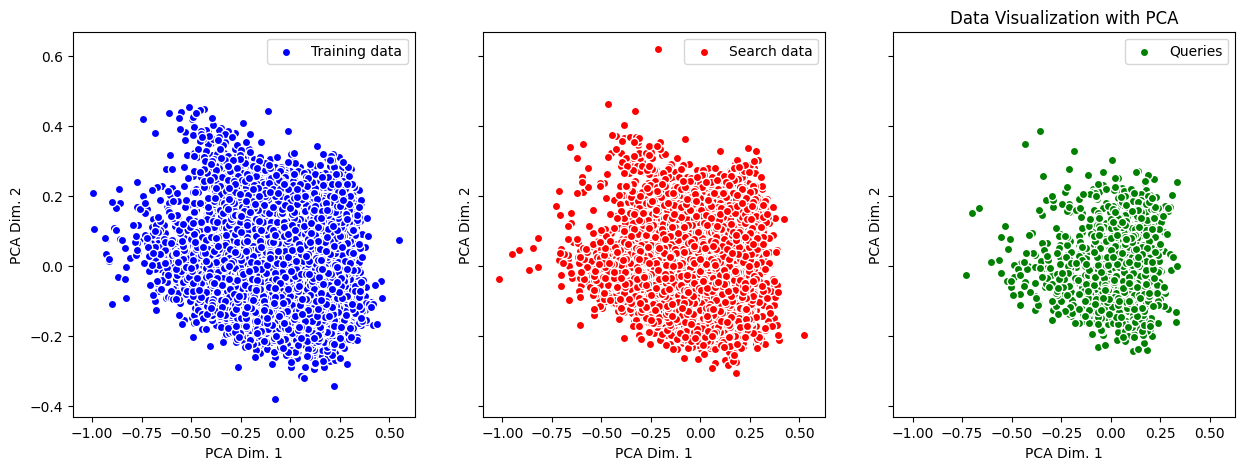

In [4]:
data = np.concatenate([tr_data, search_data, queries], axis=0)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
tr_data_pca = data_pca[:len(tr_data)]
search_data_pca = data_pca[len(tr_data) : len(tr_data)+len(search_data)]
queries_pca = data_pca[len(tr_data)+len(search_data) : ]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axs[0].scatter(x=tr_data_pca[:, 0], y=tr_data_pca[:, 1], color='blue', label='Training data', edgecolors='white')
axs[1].scatter(x=search_data_pca[:, 0], y=search_data_pca[:, 1], color='red', label='Search data', edgecolors='white')
axs[2].scatter(x=queries_pca[:, 0], y=queries_pca[:, 1], color='green', label='Queries', edgecolors='white')

for i in range(3):
    axs[i].set_xlabel('PCA Dim. 1')
    axs[i].set_ylabel('PCA Dim. 2')
    axs[i].legend()

plt.title("Data Visualization with PCA")
plt.show()

In [ ]:
if DATASET == "siftsmall": # glove and gift data have too many features
    plt.figure(figsize=(25, 5))
    plt.boxplot(tr_data)
    plt.title("Training data")
    plt.xticks([])
    plt.xlabel("Features")
    plt.figure(figsize=(25, 5))
    plt.boxplot(search_data)
    plt.title("Search data")
    plt.xticks([])
    plt.xlabel("Features")
    plt.figure(figsize=(25, 5))
    plt.boxplot(queries)
    plt.title("Queries")
    plt.xticks([])
    plt.xlabel("Features");

## Replication of the results from the article

### Product Quantization

Training the PQ quantizer:

In [6]:
if DATASET == "glove":
    M = 20
elif DATASET == "gist":
    M = 60
else:
    M = 8
K = 256
pq = PQ(M=M, K=K, seed=RANDOM_SEED)

print(f"Training the PQ quantizer with m={M}, k*={K}"
    f" (chunk size = {tr_data.shape[1] // M})...")

start_training = time.time()
pq.train(tr_data, add=False, verbose=True)
training_time = time.time() - start_training
start_adding = time.time()
pq.add(search_data)
adding_time = time.time() - start_adding

compressed_tr = pq.compress(tr_data)
decompressed_tr = pq.decompress(compressed_tr) 
error_tr = NMSE(tr_data, decompressed_tr)

decompressed_search = pq.decompress(pq.pqcode)
error_search = NMSE(search_data, decompressed_search)

results = [{
    "Training time [s]": training_time,
    "Adding time [s]": adding_time,
    "Compressed data shape": f"{pq.pqcode.shape}",
    "Compressed data size [bytes]": pq.pqcode.nbytes,
    "Original data size [bytes]": search_data.nbytes,
    "Compression factor": search_data.nbytes / pq.pqcode.nbytes,
    "NMSE on training data": error_tr,
    "NMSE on search data": error_search
}]

print("--------------------")
print(f"Training the PQ quantizer with m={M}, k*={K}"
    f" (chunk size = {tr_data.shape[1] // M}) and average distortion"
    " computation...")

start_training_d = time.time()
pq.train(tr_data, add=False, verbose=True)
training_time_d = time.time() - start_training_d
start_adding_d = time.time()
pq.add(search_data, compute_distortions=True)
adding_time_d = time.time() - start_adding_d

results.append({
    "Training time [s]": training_time_d,
    "Adding time [s]": adding_time_d,
    "Compressed data shape": f"{pq.pqcode.shape} + {pq.avg_dist.shape}",
    "Compressed data size [bytes]": pq.pqcode.nbytes + pq.avg_dist.nbytes,
    "Original data size [bytes]": search_data.nbytes,
    "Compression factor": search_data.nbytes / (pq.pqcode.nbytes + pq.avg_dist.nbytes),
    "NMSE on training data": error_tr,
    "NMSE on search data": error_search
})

pq_results_df = pd.DataFrame(
    results,
    index=["PQ without average distortion", "PQ with average distortion"]
    )
pq_results_df.style.background_gradient(cmap="Blues")

Training the PQ quantizer with m=20, k*=256 (chunk size = 15)...
KMeans on subspace 1 converged in 66 iterations with an inertia of 575.1972510447226.
KMeans on subspace 2 converged in 65 iterations with an inertia of 570.4730471718656.
KMeans on subspace 3 converged in 64 iterations with an inertia of 585.6266497891645.
KMeans on subspace 4 converged in 86 iterations with an inertia of 569.48277056598.
KMeans on subspace 5 converged in 140 iterations with an inertia of 572.1989867580821.
KMeans on subspace 6 converged in 76 iterations with an inertia of 563.508993594982.
KMeans on subspace 7 converged in 95 iterations with an inertia of 565.6113234183149.
KMeans on subspace 8 converged in 61 iterations with an inertia of 566.8353785238592.
KMeans on subspace 9 converged in 70 iterations with an inertia of 566.6791028503465.
KMeans on subspace 10 converged in 75 iterations with an inertia of 572.8861623602539.
KMeans on subspace 11 converged in 101 iterations with an inertia of 563.653

,Training time [s],Adding time [s],Compressed data shape,Compressed data size [bytes],Original data size [bytes],Compression factor,NMSE on training data,NMSE on search data
PQ without average distortion,8.125867,0.083142,"(10000, 20)",200000,24000000,120.000000,0.457657,0.492313
PQ with average distortion,7.749209,0.253702,"(10000, 20) + (20, 256)",220480,24000000,108.853411,0.457657,0.492313


Visualizing the codes distribution:

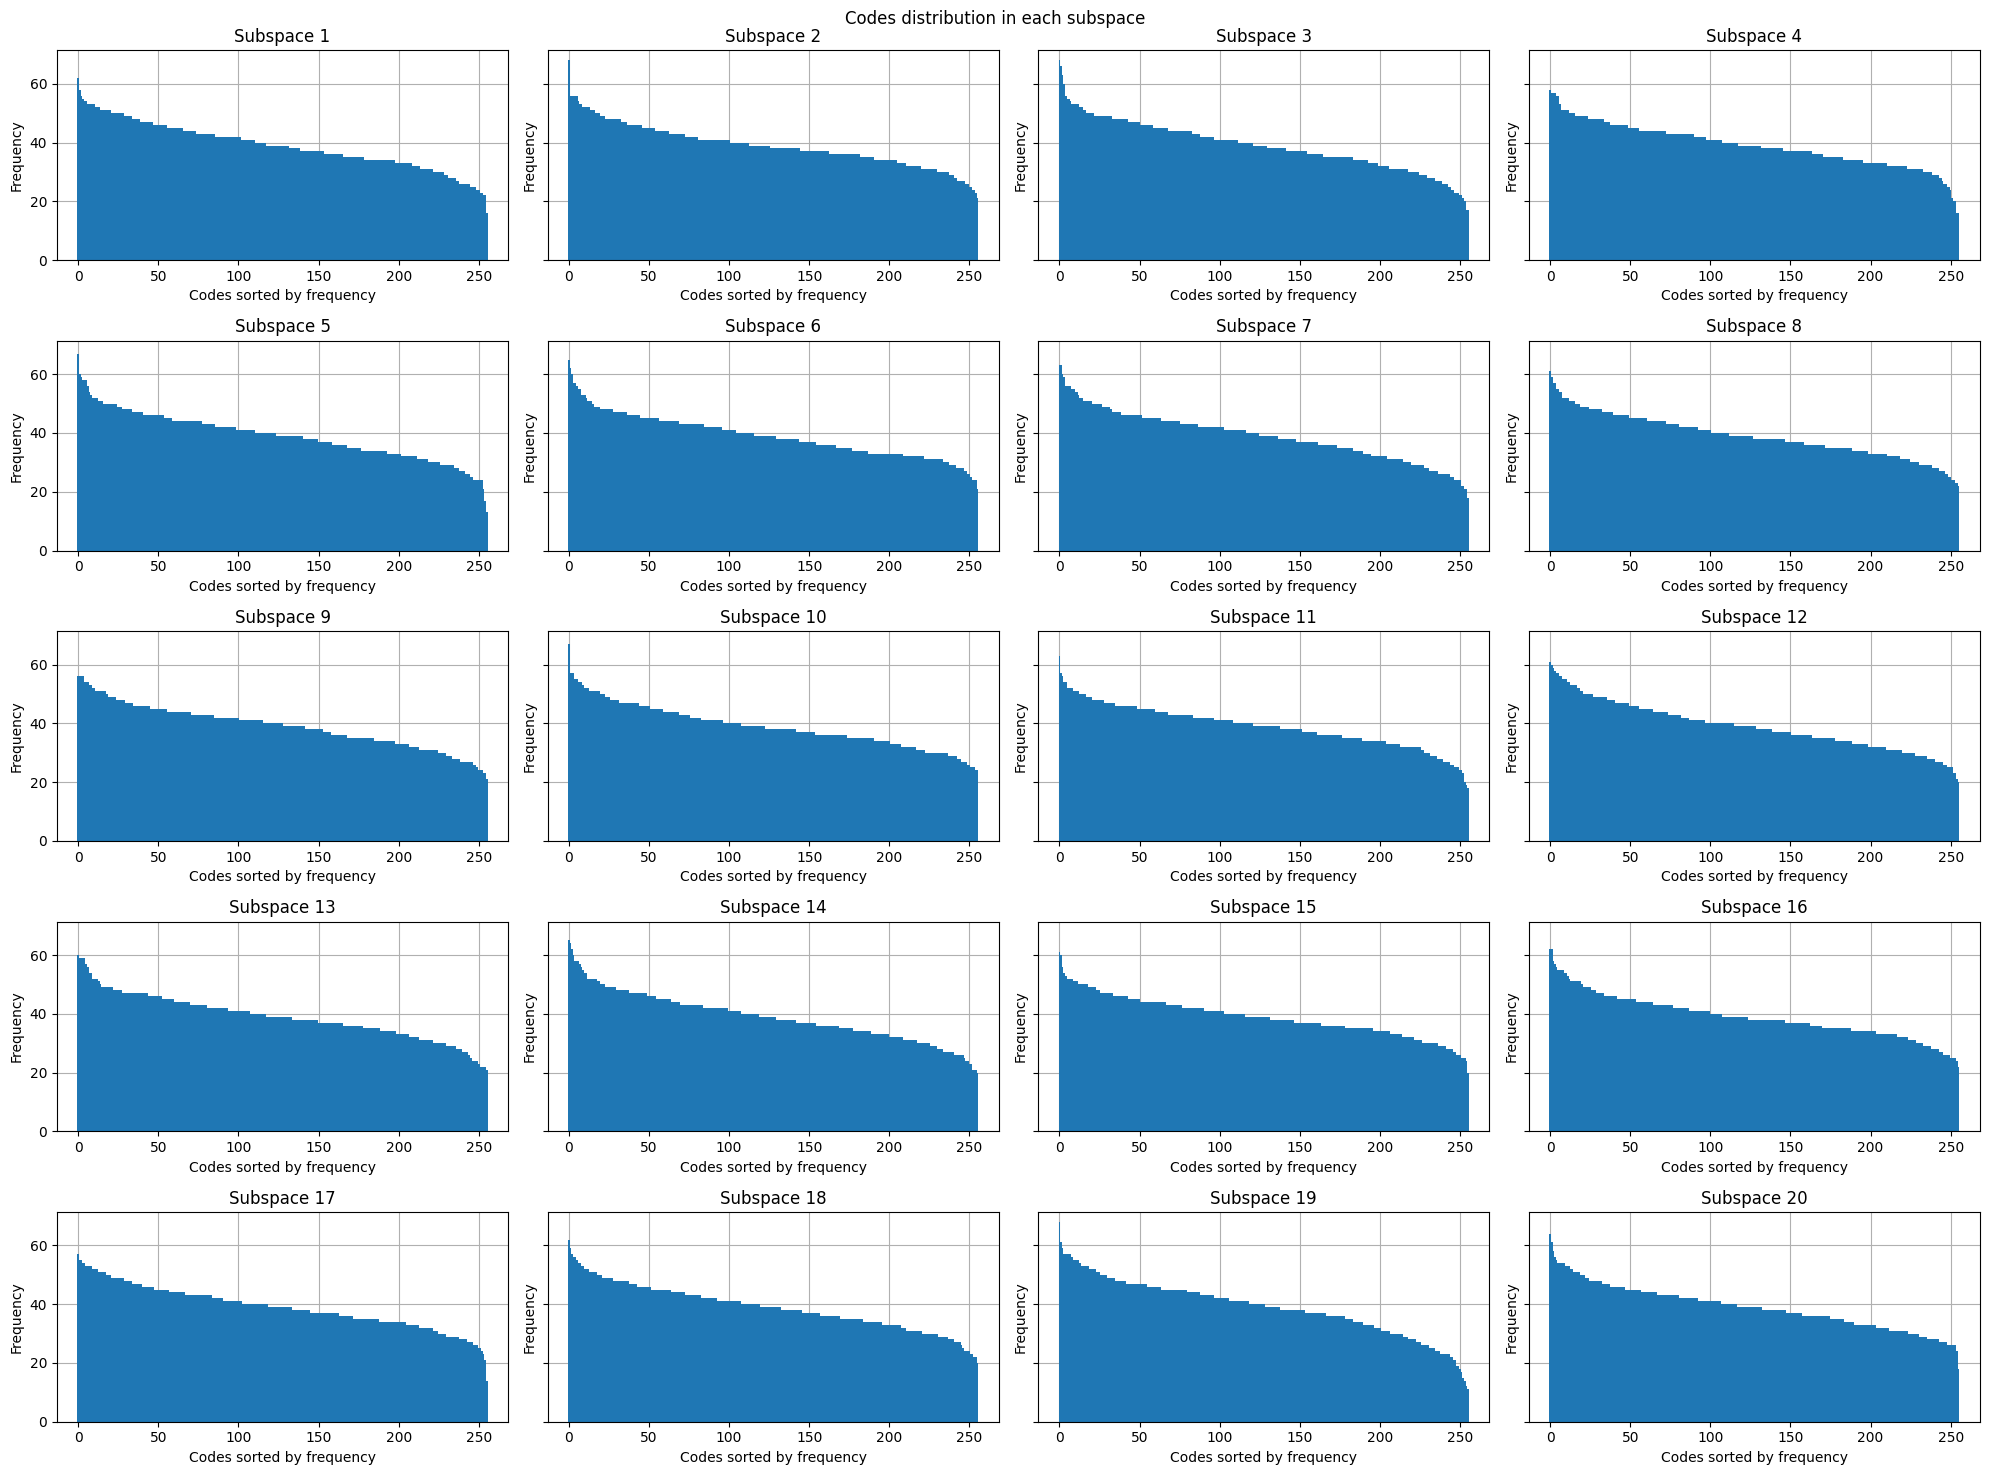

In [7]:
if DATASET == "glove":
    nrows = 5
elif DATASET == "gist":
    nrows = 15
else:
    nrows = 2
fig, axs = plt.subplots(nrows, 4, figsize=(20, 3*nrows), sharey=True)
id = 0
for m in range(pq.M):
    hist, bins = np.histogram(pq.pqcode[:, m], bins=range(pq.K+1))
    hist = sorted(hist, reverse=True)
    axs[int(id/4)][id%4].bar(bins[:-1], hist, width=1)
    axs[int(id/4)][id%4].set_title(f"Subspace {m+1}")
    axs[int(id/4)][id%4].set_xlabel("Codes sorted by frequency")
    axs[int(id/4)][id%4].set_ylabel("Frequency")
    axs[int(id/4)][id%4].grid()
    axs[int(id/4)][id%4].set_axisbelow(True)
    id += 1
plt.suptitle("Codes distribution in each subspace")
plt.tight_layout()
plt.show()

Computing the exact distances for a sample query and checking if they are equal to the given ground truth distances:

In [ ]:
es = ExactSearch(search_data)
exact_dists, exact_ranking = es.search(sample_query)
if DATASET == "siftsmall" and not SEARCH_TRAIN_SUBSET:
    print(np.all(gt[0][:100]==exact_ranking[:100]))

Defining a function to plot exact vs approximate distances from a sample query for both symmetric and asymmetric approaches:

In [9]:
def plot_exact_vs_estimated(axs, exact_dists, sym_pq_dists, asym_pq_dists, query):
    query_snorm = np.sum(np.square(query))
    exact_dists = exact_dists / query_snorm
    sym_pq_dists = sym_pq_dists / query_snorm
    asym_pq_dists = asym_pq_dists / query_snorm

    xy_sym = np.vstack([exact_dists, sym_pq_dists])
    kernel_sym = gaussian_kde(xy_sym)(xy_sym)
    axs.scatter(
        exact_dists,
        sym_pq_dists,
        c=kernel_sym,
        cmap="Reds", edgecolor="black", label="Symmetric", zorder=2, marker="o")
    
    xy_asym = np.vstack([exact_dists, asym_pq_dists])
    kernel_asym = gaussian_kde(xy_asym)(xy_asym)
    axs.scatter(
        exact_dists,
        asym_pq_dists,
        c=kernel_asym,
        cmap="Blues", edgecolor="black", label="Asymmetric", zorder=2, marker="s")

    axs.set_xlabel("True distances (normalized)")
    axs.set_ylabel("Estimated distances (normalized)")
    
    xpoints = axs.get_xlim()
    axs.plot(xpoints, xpoints, linestyle="--", color="black", zorder=1)
    
    axs.grid(zorder=0)
    axs.legend()

Computing the distances with PQ for a sample query and plotting their exact vs approximate values for a random subset of 200 database vectors:

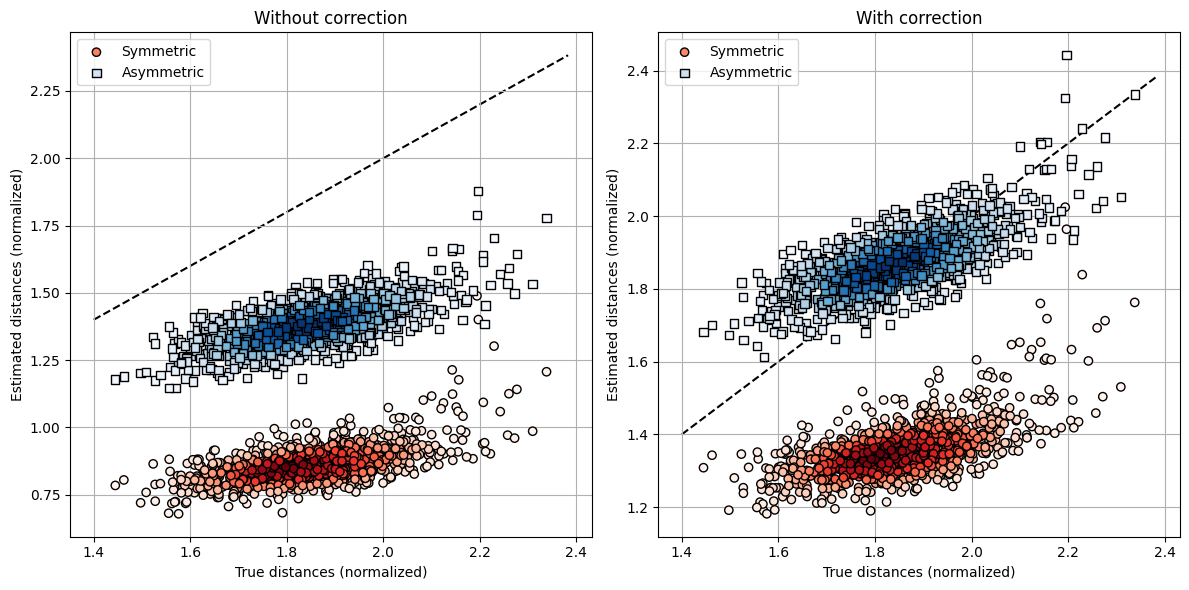

In [10]:
asym_pq_dists, asym_ranking = pq.search(sample_query, subset=None, asym=True, correct=False)
asym_pq_corr_dists, asym_corr_ranking = pq.search(sample_query, subset=None, asym=True, correct=True)
sym_pq_dists, sym_ranking = pq.search(sample_query, subset=None, asym=False, correct=False)
sym_pq_corr_dists, sym_corr_ranking = pq.search(sample_query, subset=None, asym=False, correct=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sample_size = 1000
plot_exact_vs_estimated(axs[0], exact_dists[:sample_size], sym_pq_dists[:sample_size], asym_pq_dists[:sample_size], sample_query)
axs[0].set_title("Without correction")
plot_exact_vs_estimated(axs[1], exact_dists[:sample_size], sym_pq_corr_dists[:sample_size], asym_pq_corr_dists[:sample_size], sample_query)
axs[1].set_title("With correction");
plt.tight_layout()

Using the estimated distances tends to underestimate the average distance between descriptors. The symmetric version is more affected by estimation bias compared to the asymmetric version.

Computing the differences between approximate and exact distances for all queries:

In [11]:
asym_diffs = np.zeros((search_data.shape[0] * queries.shape[0]))
asym_diffs_corr = np.zeros((search_data.shape[0] * queries.shape[0]))
sym_diffs = np.zeros((search_data.shape[0] * queries.shape[0]))
sym_diffs_corr = np.zeros((search_data.shape[0] * queries.shape[0]))

exact_ranks = np.empty((queries.shape[0], search_data.shape[0]))
mean_es_time = 0

for i, query in enumerate(queries):
    asym_d_est, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
    asym_d_est_corr, asym_corr_rank = pq.search(query, subset=None, asym=True, correct=True)
    sym_d_est, sym_rank = pq.search(query, subset=None, asym=False, correct=False)
    sym_d_est_corr, sym_corr_rank = pq.search(query, subset=None, asym=False, correct=True)

    start_search_time = time.time()
    d, rank = es.search(query)
    mean_es_time += time.time() - start_search_time
    exact_ranks[i] = rank

    query_snorm = np.sum(np.square(query))
    asym_diffs[i*search_data.shape[0] : (i+1)*search_data.shape[0]] = (asym_d_est-d) / query_snorm
    asym_diffs_corr[i*search_data.shape[0] : (i+1)*search_data.shape[0]] = (asym_d_est_corr-d) / query_snorm
    sym_diffs[i*search_data.shape[0] : (i+1)*search_data.shape[0]] = (sym_d_est-d) / query_snorm
    sym_diffs_corr[i*search_data.shape[0] : (i+1)*search_data.shape[0]] = (sym_d_est_corr-d) / query_snorm

mean_es_time /= queries.shape[0]

Plotting the distribution of the computed differences:

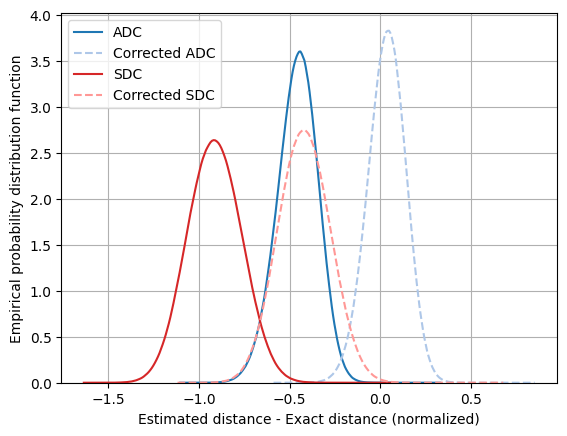

In [12]:
sns.kdeplot(asym_diffs, label="ADC", color=tab20(0))
sns.kdeplot(asym_diffs_corr, label="Corrected ADC", color=tab20(1), linestyle='dashed')
sns.kdeplot(sym_diffs, label="SDC", color=tab20(6))
sns.kdeplot(sym_diffs_corr, label="Corrected SDC", color=tab20(7), linestyle='dashed')
plt.xlabel("Estimated distance - Exact distance (normalized)")
plt.ylabel("Empirical probability distribution function")
plt.legend();
plt.grid()

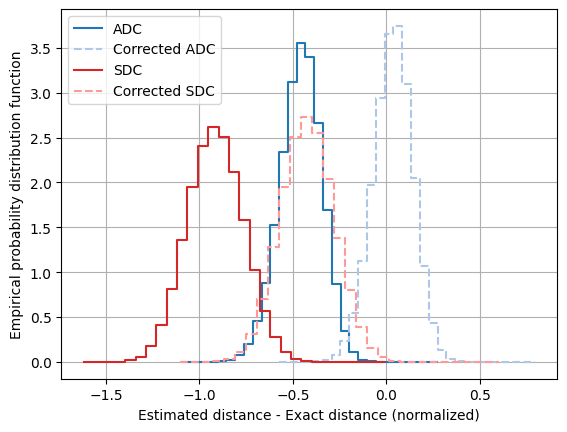

In [13]:
bins = 30

hist_asym, bin_edges_asym = np.histogram(asym_diffs, bins=bins, density=True)
plt.step(bin_edges_asym[:-1], hist_asym, where='post', label="ADC", color=tab20(0))

hist_asym_corr, bin_edges_asym_corr = np.histogram(asym_diffs_corr, bins=bins, density=True)
plt.step(bin_edges_asym_corr[:-1], hist_asym_corr, where='post', label="Corrected ADC", color=tab20(1), linestyle='dashed')

hist_sym, bin_edges_sym = np.histogram(sym_diffs, bins=bins, density=True)
plt.step(bin_edges_sym[:-1], hist_sym, where='post', label="SDC", color=tab20(6))

hist_sym_corr, bin_edges_sym_corr = np.histogram(sym_diffs_corr, bins=bins, density=True)
plt.step(bin_edges_sym_corr[:-1], hist_sym_corr, where='post', label="Corrected SDC", color=tab20(7), linestyle='dashed')

plt.xlabel("Estimated distance - Exact distance (normalized)")
plt.ylabel("Empirical probability distribution function")
plt.legend()
plt.grid()

The bias of the distance estimation is significantly reduced in the corrected version.

Computing the variance of the differences:

In [14]:
asym_diff_var = np.var(asym_diffs)
asym_corr_diff_var = np.var(asym_diffs_corr)
sym_diff_var = np.var(sym_diffs)
sym_corr_diff_var = np.var(sym_diffs_corr)
pd.DataFrame({
    "ADC": [asym_diff_var],
    "Corrected ADC": [asym_corr_diff_var],
    "SDC": [sym_diff_var],
    "Corrected SDC": [sym_corr_diff_var],
    }, index=["Variance of error"]).T.style.background_gradient(cmap='Blues')

,Variance of error
ADC,0.012546
Corrected ADC,0.010967
SDC,0.021888
Corrected SDC,0.020413


On the "siftsmall" dataset, correcting the bias leads to a higher variance of the estimator.

Defining a function to compute the average recall at various values of R for a set of queries. Both the "nearest recall at R" and "recall at R" are computed: the former measures the proportion of query vectors for which the nearest neighbor is ranked in the first R positions, while the latter measures the average recall at R. In the original article, only "nearest recall at R is analyzed, with the authors noting that the conclusions are similar for recall at R.

In [15]:
def compute_recall(index, R, queries, exact_ranks, w=4, correct=True, sym=True):
    """
    Compute average recall at all values in R for the given index and queries.

    Parameters
    ----------

    index : PQ or IVF
        The index to use for the search.
    
    R : list
        The list of values for which to compute the recall at.

    queries : np.ndarray
        The queries to use for the search.

    exact_ranks : np.ndarray
        The exact ranking of the search data for each query.

    w : int
        The number of centroids to visit in the IVF index.

    correct : bool
        Whether to compute also the corrected distances.

    sym : bool
        Whether to compute also the symmetric distances.

    Returns
    -------

    results : dict
        A dictionary containing the mean recall at each value of R for the
        asymmetric and symmetric distances, with and without correction, as
        well as the attribute `inertia` of the index.
        Recall is computed both as the number of relevant items in the top R,
        and as the presence of the nearest item in the top R (nearest recall).
    
    """

    asym_recall = np.full((len(queries), len(R)), np.nan)
    nearest_asym_recall = np.full((len(queries), len(R)), np.nan)
    asym_corr_recall = np.full((len(queries), len(R)), np.nan)  
    nearest_asym_corr_recall = np.full((len(queries), len(R)), np.nan)
    sym_recall = np.full((len(queries), len(R)), np.nan)
    nearest_sym_recall = np.full((len(queries), len(R)), np.nan)
    sym_corr_recall = np.full((len(queries), len(R)), np.nan)
    nearest_sym_corr_recall = np.full((len(queries), len(R)), np.nan)

    for i, query in enumerate(queries):
        if type(index) == PQ:
            _, asym_rank = index.search(query, subset=None, asym=True, correct=False)
            if correct:
                _, asym_corr_rank = index.search(query, subset=None, asym=True, correct=True)
            if sym:
                _, sym_rank = index.search(query, subset=None, asym=False, correct=False)
                if correct:
                    _, sym_corr_rank = index.search(query, subset=None, asym=False, correct=True)
        else:
            _, asym_rank = index.search(query, w=w, asym=True, correct=False)
            if correct:
                _, asym_corr_rank = index.search(query, w=w, asym=True, correct=True)
            if sym:
                _, sym_rank = index.search(query, w=w, asym=False, correct=False)
                if correct:
                    _, sym_corr_rank = index.search(query, w=w, asym=False, correct=True)

        for j, r in enumerate(R):
            if r <= len(asym_rank):
                asym_recall[i][j] = recall_at_r(asym_rank, exact_ranks[i], r)
                nearest_asym_recall[i][j] = exact_ranks[i][0] in asym_rank[:r]
            if correct and r <= len(asym_corr_rank):
                asym_corr_recall[i][j] = recall_at_r(asym_corr_rank, exact_ranks[i], r)
                nearest_asym_corr_recall[i][j] = exact_ranks[i][0] in asym_corr_rank[:r]
            if sym:
                if r <= len(sym_rank):
                    sym_recall[i][j] = recall_at_r(sym_rank, exact_ranks[i], r)
                    nearest_sym_recall[i][j] = exact_ranks[i][0] in sym_rank[:r]
                if correct and r <= len(sym_corr_rank):
                    sym_corr_recall[i][j] = recall_at_r(sym_corr_rank, exact_ranks[i], r)
                    nearest_sym_corr_recall[i][j] = exact_ranks[i][0] in sym_corr_rank[:r]

    # Catch the warning risen when the number of retrieved items for all the
    # queries is smaller than some value of R
    with warnings.catch_warnings(record=True) as w:
        asym_recall_mean = np.nanmean(asym_recall, axis=0)
        nearest_asym_recall_mean = np.nanmean(nearest_asym_recall, axis=0)
        asym_corr_recall_mean = np.nanmean(asym_corr_recall, axis=0)
        nearest_asym_corr_recall_mean = np.nanmean(nearest_asym_corr_recall, axis=0)
        sym_recall_mean = np.nanmean(sym_recall, axis=0)
        nearest_sym_recall_mean = np.nanmean(nearest_sym_recall, axis=0)
        sym_corr_recall_mean = np.nanmean(sym_corr_recall, axis=0)
        nearest_sym_corr_recall_mean = np.nanmean(nearest_sym_corr_recall, axis=0)
        if w:
            for warning in w:
                if "Mean of empty slice" not in str(warning.message):
                    warnings.warn(warning.message, warning.category)

    results = {
        "asym_recall_mean": asym_recall_mean,
        "nearest_asym_recall_mean": nearest_asym_recall_mean,
        "asym_corr_recall_mean": asym_corr_recall_mean,
        "nearest_asym_corr_recall_mean": nearest_asym_corr_recall_mean,
        "sym_recall_mean": sym_recall_mean,
        "nearest_sym_recall_mean": nearest_sym_recall_mean,
        "sym_corr_recall_mean": sym_corr_recall_mean,
        "nearest_sym_corr_recall_mean": nearest_sym_corr_recall_mean,
        "inertia": index.inertia
    }

    return results

Computing the average recall at various values of R for the set of queries:

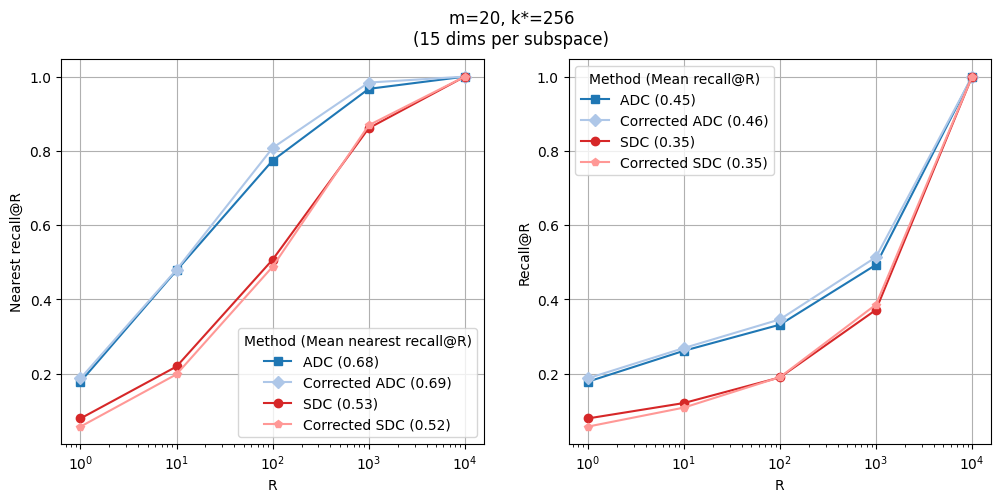

In [16]:
R = [1, 10, 100, 1000, 10000]

results_pq = compute_recall(pq, R, queries, exact_ranks)
results_pq["search_NMSE"] = NMSE(search_data, pq.decompress(pq.pqcode))
del pq

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_pq["nearest_asym_recall_mean"], '-s', label=f"ADC ({np.mean(results_pq['nearest_asym_recall_mean']):.2f})", color=tab20(0))
axs[0].plot(R, results_pq["nearest_asym_corr_recall_mean"], '-D', label=f"Corrected ADC ({np.mean(results_pq['nearest_asym_corr_recall_mean']):.2f})", color=tab20(1))
axs[0].plot(R, results_pq["nearest_sym_recall_mean"], '-o', label=f"SDC ({np.mean(results_pq['nearest_sym_recall_mean']):.2f})", color=tab20(6))
axs[0].plot(R, results_pq["nearest_sym_corr_recall_mean"], '-p', label=f"Corrected SDC ({np.mean(results_pq['nearest_sym_corr_recall_mean']):.2f})", color=tab20(7))
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title="Method (Mean nearest recall@R)")
axs[0].grid()

axs[1].plot(R, results_pq["asym_recall_mean"], '-s', label=f"ADC ({np.mean(results_pq['asym_recall_mean']):.2f})", color=tab20(0))
axs[1].plot(R, results_pq["asym_corr_recall_mean"], '-D', label=f"Corrected ADC ({np.mean(results_pq['asym_corr_recall_mean']):.2f})", color=tab20(1))
axs[1].plot(R, results_pq["sym_recall_mean"], '-o', label=f"SDC ({np.mean(results_pq['sym_recall_mean']):.2f})", color=tab20(6))
axs[1].plot(R, results_pq["sym_corr_recall_mean"], '-p', label=f"Corrected SDC ({np.mean(results_pq['sym_corr_recall_mean']):.2f})", color=tab20(7))
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title="Method (Mean recall@R)")
axs[1].grid()

fig.suptitle(f"m={M}, k*={K}\n({tr_data.shape[1]//M} dims per subspace)");

Computing the average recall at 100 for the set of queries with different values of M and K:

In [17]:
Ms = [1, 2, 4, 10, 20] if DATASET == "glove" else [1, 2, 4, 8, 16]
Ks = [16, 64, 256, 1024]

training_results = []
search_results = []

for m in Ms:
    for k in Ks:
        print(f"Training PQ with m={m}, k*={k}...")
        
        pq = PQ(M=m, K=k, seed=RANDOM_SEED)
        start_training = time.time()
        pq.train(tr_data, add=False)
        training_time = time.time() - start_training
        start_adding = time.time()
        pq.add(search_data)
        adding_time = time.time() - start_adding
        
        decompressed_search = pq.decompress(pq.pqcode) 
        search_NMSE = NMSE(search_data, decompressed_search)
        compressed_tr = pq.compress(tr_data)
        decompressed_tr = pq.decompress(compressed_tr)
        tr_NMSE = NMSE(tr_data, decompressed_tr)

        code_length = int(np.log2(k)) * m
        curr_training_res = {
            "m": m, "k*": k, "Code length [bits]": code_length,
            "Training time [s]": training_time, "Adding time [s]": adding_time,
            "TR NMSE": tr_NMSE,
            "SEARCH NMSE": search_NMSE
        }
        training_results.append(curr_training_res)
        
        for asym in [True, False]:
            mean_search_time = 0
            nearest_recall_tr = 0
            for i, query in enumerate(queries):
                start_search = time.time()
                _, ranking = pq.search(query, subset=None, asym=asym, correct=False)
                mean_search_time += (time.time() - start_search)
                if exact_ranks[i][0] in ranking[:100]:
                    nearest_recall_tr += 1
            mean_search_time /= queries.shape[0]
            nearest_recall_tr /= queries.shape[0]
            
            curr_search_res = {
                "m": m, "k*": k, "Code length [bits]": code_length,
                "Asymmetric Distance": asym,
                "Mean search time [ms]": mean_search_time*1000,
                "Nearest recall@100": nearest_recall_tr
            }
            search_results.append(curr_search_res)

del pq
training_results = pd.DataFrame(training_results)
search_results = pd.DataFrame(search_results)

Training PQ with m=1, k*=16...
Training PQ with m=1, k*=64...
Training PQ with m=1, k*=256...
Training PQ with m=1, k*=1024...
Training PQ with m=2, k*=16...
Training PQ with m=2, k*=64...
Training PQ with m=2, k*=256...
Training PQ with m=2, k*=1024...
Training PQ with m=4, k*=16...
Training PQ with m=4, k*=64...
Training PQ with m=4, k*=256...
Training PQ with m=4, k*=1024...
Training PQ with m=10, k*=16...
Training PQ with m=10, k*=64...
Training PQ with m=10, k*=256...
Training PQ with m=10, k*=1024...
Training PQ with m=20, k*=16...
Training PQ with m=20, k*=64...
Training PQ with m=20, k*=256...
Training PQ with m=20, k*=1024...


Displaying the results about the training:

In [18]:
training_results.style.background_gradient(
    subset=["Training time [s]", "Adding time [s]", "TR NMSE", "SEARCH NMSE"],
    cmap='Blues'
)

,m,k*,Code length [bits],Training time [s],Adding time [s],TR NMSE,SEARCH NMSE
0,1,16,4,0.249080,0.008905,0.839350,0.841023
1,1,64,6,0.429993,0.010952,0.808701,0.815062
2,1,256,8,1.226941,0.015776,0.770534,0.791764
3,1,1024,10,2.812138,0.091336,0.720423,0.786176
4,2,16,8,0.350110,0.006869,0.832232,0.834206
5,2,64,12,0.661989,0.009862,0.798493,0.806660
6,2,256,16,1.591606,0.022121,0.758601,0.784218
7,2,1024,20,3.416723,0.054134,0.703781,0.774319
8,4,16,16,0.577959,0.009275,0.815369,0.818426
9,4,64,24,1.391372,0.011917,0.773415,0.784658


Plotting the reconstruction error:

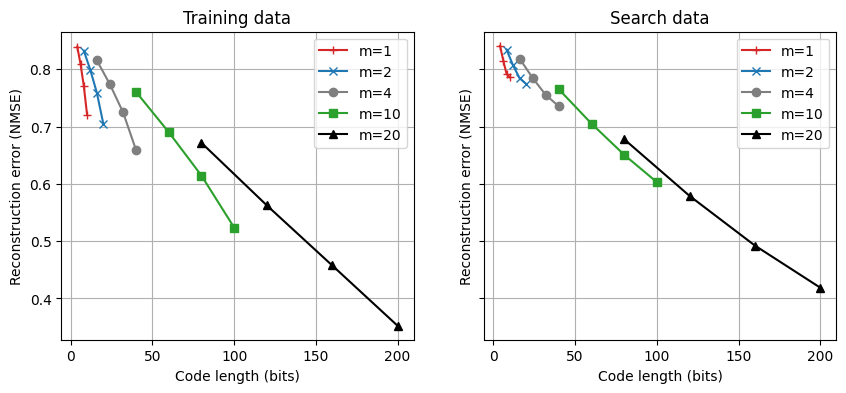

In [19]:
colors = ['tab:red', 'tab:blue', 'tab:gray', 'tab:green', 'black']
markers = ['+', 'x', 'o', 's', '^', 'D']

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i, m in enumerate(Ms):
    res = training_results[training_results["m"]==m]
    axs[0].plot(res["Code length [bits]"], res["TR NMSE"], marker=markers[i], color=colors[i], label=f"m={m}")
    axs[1].plot(res["Code length [bits]"], res["SEARCH NMSE"], marker=markers[i], color=colors[i], label=f"m={m}")

if DATASET != "glove":
    axs[0].set_xticks([16, 32, 64, 96, 128, 160])
    axs[1].set_xticks([16, 32, 64, 96, 128, 160])

axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Reconstruction error (NMSE)")
axs[0].set_title("Training data")
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Reconstruction error (NMSE)")
axs[1].set_title("Search data")
axs[1].legend()
axs[1].grid()

For a fixed number of bits, it is better to use a small number of subquantizers with many centroids than having many subquantizers with few bits.

Displaying the results about the search:

In [20]:
print(f"Mean Exact Search time: {mean_es_time*1000} [ms]")
search_results.style.background_gradient(
    subset=["Mean search time [ms]", "Nearest recall@100"],
    cmap='Blues'
)

Mean Exact Search time: 3.5510432720184326 [ms]


,m,k*,Code length [bits],Asymmetric Distance,Mean search time [ms],Nearest recall@100
0,1,16,4,True,0.308849,0.079000
1,1,16,4,False,0.315375,0.093000
2,1,64,6,True,0.387552,0.207000
3,1,64,6,False,0.450518,0.224000
4,1,256,8,True,0.503185,0.313000
5,1,256,8,False,0.596199,0.265000
6,1,1024,10,True,0.600440,0.353000
7,1,1024,10,False,0.997209,0.270000
8,2,16,8,True,0.601306,0.138000
9,2,16,8,False,0.628850,0.130000


Plotting the average recall at 100:

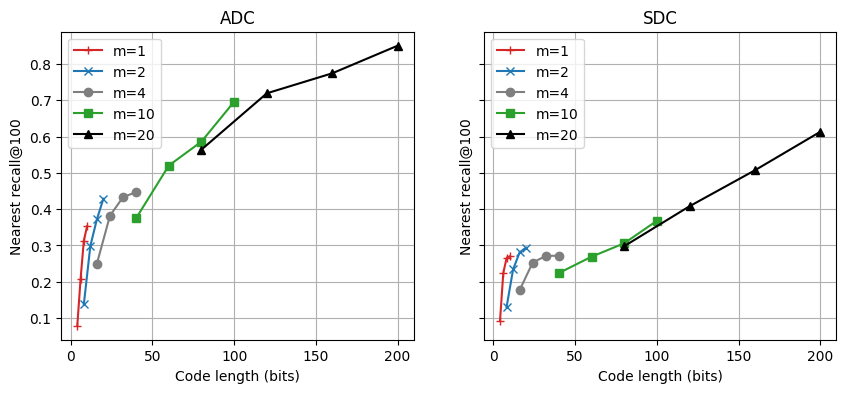

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i, m in enumerate(Ms):
    asym_res = search_results[(search_results["m"]==m) & (search_results["Asymmetric Distance"]==True)]
    axs[0].plot(asym_res["Code length [bits]"], asym_res["Nearest recall@100"], marker=markers[i], color=colors[i], label=f"m={m}")
    sym_res = search_results[(search_results["m"]==m) & (search_results["Asymmetric Distance"]==False)]
    axs[1].plot(sym_res["Code length [bits]"], sym_res["Nearest recall@100"], marker=markers[i], color=colors[i], label=f"m={m}")

if DATASET != "glove":
    axs[0].set_xticks([16, 32, 64, 96, 128, 160])
    axs[1].set_xticks([16, 32, 64, 96, 128, 160])

axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Nearest recall@100")
axs[0].set_title("ADC")
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Nearest recall@100")
axs[1].set_title("SDC")
axs[1].legend()
axs[1].grid()

The asymmetric estimator ADC significantly outperforms SDC. On the "siftsmall" dataset, for $m=8$, ADC achieves higher accuracy with $k=64$ compared to SDC with $k=256$. Given that the efficiency of the two approaches is equivalent, the authors advocate not to quantize the query when possible, but only the database elements.

Plotting the search time:

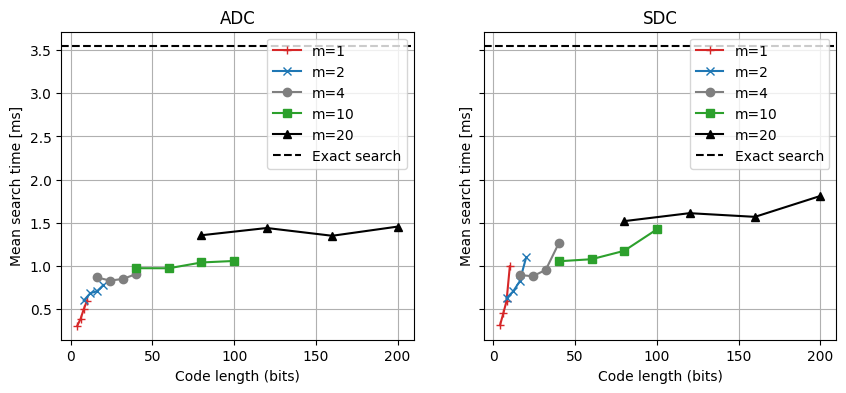

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i, m in enumerate(Ms):
    asym_res = search_results[(search_results["m"]==m) & (search_results["Asymmetric Distance"]==True)]
    axs[0].plot(asym_res["Code length [bits]"], asym_res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"m={m}")
    sym_res = search_results[(search_results["m"]==m) & (search_results["Asymmetric Distance"]==False)]
    axs[1].plot(sym_res["Code length [bits]"], sym_res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")
axs[1].axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")

if DATASET == "siftsmall":
    axs[0].set_xticks([16, 32, 64, 96, 128, 160])
    axs[1].set_xticks([16, 32, 64, 96, 128, 160])

axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Mean search time [ms]")
axs[0].set_title("ADC")
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Mean search time [ms]")
axs[1].set_title("SDC")
axs[1].legend()
axs[1].grid()

SIFT descriptors are constructed as concatenated orientation histograms. Each histogram is calculated within grid cells of an image patch, as illustrated in the figure below (sourced from "Computer Vision Metrics - Survey, Taxonomy, and Analysis", by Scott Krigg).

<img src="./img/sift.png" alt="My Image" width="500"/>

Using a product quantizer, histogram bins may be assigned to different quantization groups. The "natural" order groups consecutive components, while the "structured" order clusters related dimensions—for example, grouping 2x2 patches when M=4. To assess the impact of these grouping strategies, we also compare them to a "random" order.

In [23]:
if DATASET == "siftsmall":
    # Prepare data for the structured permutation
    struct_perm = list(range(0, 16)) + list(range(32, 48)) + \
        list(range(16, 32)) + list(range(48, 64)) + \
        list(range(64, 80)) + list(range(96, 112)) + \
        list(range(80, 96)) + list(range(112, 128))
    tr_data_struct = tr_data[:, struct_perm]
    queries_struct = queries[:, struct_perm]
    search_data_struct = search_data[:, struct_perm]

    # Compute recall for the structured permutation when training and searching
    # on different data
    pq_struct = PQ(M=4, K=K, seed=RANDOM_SEED)
    print("Training PQ with structured permutation on training data...")
    pq_struct.train(tr_data_struct, add=False)
    pq_struct.add(search_data_struct)
    results_struct_disj = compute_recall(
        index=pq_struct, R=[10], queries=queries_struct,
        exact_ranks=exact_ranks, correct=False,
        sym=False
    )
    recall_struct_perm_disj = results_struct_disj["nearest_asym_recall_mean"][0]
    del pq_struct

    # Compute recall for the natural permutation when training and searching
    # on different data
    pq = PQ(M=4, K=K, seed=RANDOM_SEED)
    print("Training PQ with natural permutation on training data...")
    pq.train(tr_data, add=False)
    pq.add(search_data)
    results_disj = compute_recall(
        index=pq, R=[10], queries=queries,
        exact_ranks=exact_ranks, correct=False,
        sym=False
    )
    recall_disj = results_disj["nearest_asym_recall_mean"][0]
    del pq

    recalls_rand_disj = []
    for rep in range(0, 5):
        # Prepare data for the random permutation
        rand_perm = np.random.permutation(128)
        tr_data_rand = tr_data[:, rand_perm]
        queries_rand = queries[:, rand_perm]
        search_data_rand = search_data[:, rand_perm]

        # Compute recall for the random permutation when training and searching
        # on different data
        pq_rand = PQ(M=4, K=K, seed=RANDOM_SEED)
        print(f"[{rep+1}/5] Training PQ with random permutation on training data...")
        pq_rand.train(tr_data_rand, add=False)
        pq_rand.add(search_data_rand)
        results_rand_disj = compute_recall(
            index=pq_rand, R=[10], queries=queries_rand,
            exact_ranks=exact_ranks, correct=False,
            sym=False
        )
        recall_rand_disj = results_rand_disj["nearest_asym_recall_mean"][0]
        recalls_rand_disj.append(recall_rand_disj)

    del pq_rand
    recall_rand_mean_disj = np.mean(recalls_rand_disj)
    recall_rand_std_disj = np.std(recalls_rand_disj)

    # Compute recall for the structured permutation when training and searching
    # on the same data
    pq_struct = PQ(M=4, K=K, seed=RANDOM_SEED)
    print("Training PQ with structured permutation on search data...")
    pq_struct.train(search_data_struct, add=True)
    results_perm = compute_recall(
        index=pq_struct, R=[10], queries=queries_struct,
        exact_ranks=exact_ranks, correct=False, sym=False
    )
    recall_struct = results_perm["nearest_asym_recall_mean"][0]

    # Compute recall for the natural permutation when training and searching
    # on the same data
    print("Training PQ with natural permutation on search data...")
    pq = PQ(M=4, K=K, seed=RANDOM_SEED)
    pq.train(search_data, add=True)
    results_search = compute_recall(
        index=pq, R=[10], queries=queries,
        exact_ranks=exact_ranks, correct=False, sym=False
    )
    recall_search = results_search["nearest_asym_recall_mean"][0]

    recalls_rand = []
    for rep in range(0, 5):
        # Prepare data for the random permutation
        rand_perm = np.random.permutation(128)
        tr_data_rand = tr_data[:, rand_perm]
        queries_rand = queries[:, rand_perm]
        search_data_rand = search_data[:, rand_perm]
        
        # Compute recall for the random permutation when training and searching
        # on the same data
        print(f"[{rep+1}/5] Training PQ with random permutation on search data...")
        pq_rand = PQ(M=4, K=K, seed=RANDOM_SEED)
        pq_rand.train(search_data_rand, add=True)
        results_random = compute_recall(
            index=pq_rand, R=[10], queries=queries_rand,
            exact_ranks=exact_ranks, correct=False, sym=False
        )
        recall_rand = results_random["nearest_asym_recall_mean"][0]
        recalls_rand.append(recall_rand)

    del pq_rand
    recall_rand_mean = np.mean(recalls_rand)
    recall_rand_std = np.std(recalls_rand)

    display(pd.DataFrame({
        "natural": [nearest_recall_tr, recall_search],
        "structured": [recall_struct_perm_disj, recall_struct],
        "random mean": [recall_rand_mean_disj, recall_rand_mean],
        "random std": [recall_rand_std_disj, recall_rand_std]
    }, index=[
        "nearest recall@10 (training data)",
        "nearest recall@10 (search data)"
        ]
    ).style.background_gradient(cmap='Blues', axis=1))

Evaluating the impact of KMeans initialization on the search performance:

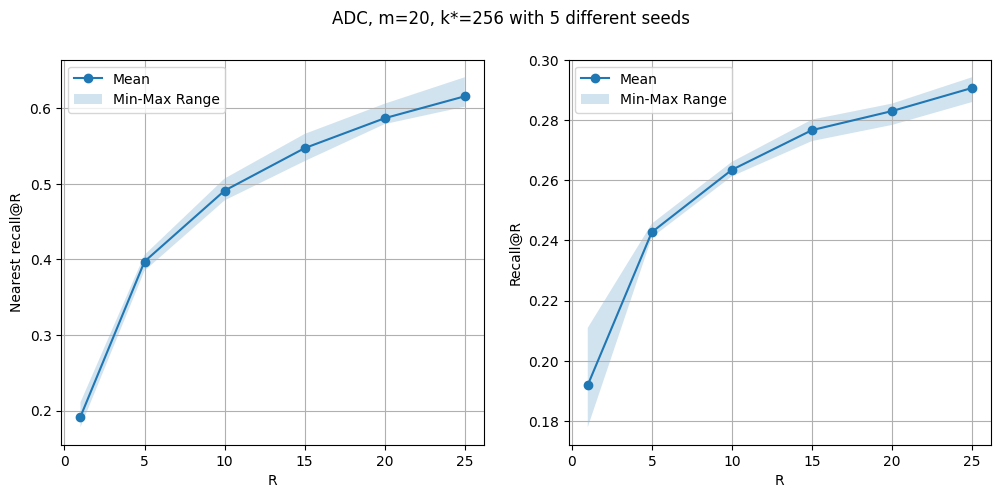

In [24]:
def compute_PQ_recall(M, K, seed, R, tr_data, search_data, queries, exact_ranks):
    pq = PQ(M=M, K=K, seed=seed)
    pq.train(tr_data, add=False)
    pq.add(search_data, compute_distortions=False)
    results = compute_recall(pq, R, queries, exact_ranks, correct=False, sym=False)
    return results

R_small = [1, 5, 10, 15, 20, 25]

results_pq_seeds = []
for i in range(5):
    results = compute_PQ_recall(M, K, RANDOM_SEED+i, R_small, tr_data, search_data, queries, exact_ranks)
    results_pq_seeds.append(results)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

nearest_asym_recall_means_seeds = np.array([results["nearest_asym_recall_mean"] for results in results_pq_seeds])
mean_nearest_seeds = nearest_asym_recall_means_seeds.mean(axis=0)
min_nearest_seeds = nearest_asym_recall_means_seeds.min(axis=0)
max_nearest_seeds = nearest_asym_recall_means_seeds.max(axis=0)

axs[0].plot(R_small, mean_nearest_seeds, marker='o', label='Mean')
axs[0].fill_between(R_small, min_nearest_seeds, max_nearest_seeds, alpha=0.2, label='Min-Max Range')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].grid()
axs[0].legend()

asym_recall_means_seeds = np.array([results["asym_recall_mean"] for results in results_pq_seeds])
mean_asym_seeds = asym_recall_means_seeds.mean(axis=0)
min_asym_seeds = asym_recall_means_seeds.min(axis=0)
max_asym_seeds = asym_recall_means_seeds.max(axis=0)

axs[1].plot(R_small, mean_asym_seeds, marker='o', label='Mean')
axs[1].fill_between(R_small, min_asym_seeds, max_asym_seeds, alpha=0.2, label='Min-Max Range')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].grid()
axs[1].legend()

fig.suptitle(f"ADC, m={M}, k*={K} with 5 different seeds")
plt.show()

In [25]:
stds = np.std([results["nearest_asym_recall_mean"] for results in results_pq_seeds], axis=0)
seeds_res_df = pd.DataFrame(stds, index=R_small, columns=["Standard deviation of nearest recall @ R"])
seeds_res_df.index.name = "R"
seeds_res_df.style.background_gradient(cmap='Blues')

,Standard deviation of nearest recall @ R
R,
1,0.011009
5,0.007054
10,0.009818
15,0.011444
20,0.009786
25,0.014119


In [26]:
if DATASET == "siftsmall":
    fig, axs = plt.subplots(1, M, figsize=(15, 4))

    for i in range(M):
        for j, results in enumerate(results_pq_seeds):
            axs[i].scatter(i, results["inertia"][i], color=tab10(j), marker=markers[j])
            axs[i].set_xticks([])
            axs[i].set_xlabel(f"Subspace {i+1}")

    fig.suptitle("Inertia for different seeds and subspaces")
    fig.tight_layout()

### Product Quantization with InVerted File index (IVF)

**Implementation details**

Rather than storing the vector ID and its code in the inverted list, as shown in the following figure from the original article, we store only the row index of the vector in the database's matrix of vectors. During a search, we retrieve the inverted index lists whose centroids are closest to the query vector and limit the search to those vectors by passing their indices to the PQ class's search method.

<img src="./img/ivf.png" width="400">

Training the PQ quantizer with IVF:

In [27]:
KP = 128
W = 8

ivf = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
start_training_ivf = time.time()
ivf.train(tr_data, add=False, verbose=True)
training_ivf = time.time() - start_training_ivf

start_adding_ivf = time.time()
ivf.add(search_data, compute_distortions=True)
adding_ivf = time.time() - start_adding_ivf

pd.DataFrame({
    "Training time [s]": training_ivf,
    "Adding time [s]": adding_ivf,
}, index=["With average distance computation"])

Coarse clustering algorithm converged in 55 iterations.
KMeans on subspace 1 converged in 61 iterations with an inertia of 510.687242308934.
KMeans on subspace 2 converged in 72 iterations with an inertia of 511.67635609931506.
KMeans on subspace 3 converged in 108 iterations with an inertia of 515.3968877761713.
KMeans on subspace 4 converged in 88 iterations with an inertia of 514.623773430207.
KMeans on subspace 5 converged in 162 iterations with an inertia of 510.78385581858083.
KMeans on subspace 6 converged in 96 iterations with an inertia of 509.3108939720776.
KMeans on subspace 7 converged in 70 iterations with an inertia of 510.01855921672745.
KMeans on subspace 8 converged in 60 iterations with an inertia of 507.8626087544254.
KMeans on subspace 9 converged in 82 iterations with an inertia of 513.1187666563832.
KMeans on subspace 10 converged in 57 iterations with an inertia of 520.083426919883.
KMeans on subspace 11 converged in 87 iterations with an inertia of 509.754068890

,Training time [s],Adding time [s]
With average distance computation,8.952345,0.267658


Visualizing the index lists lengths:

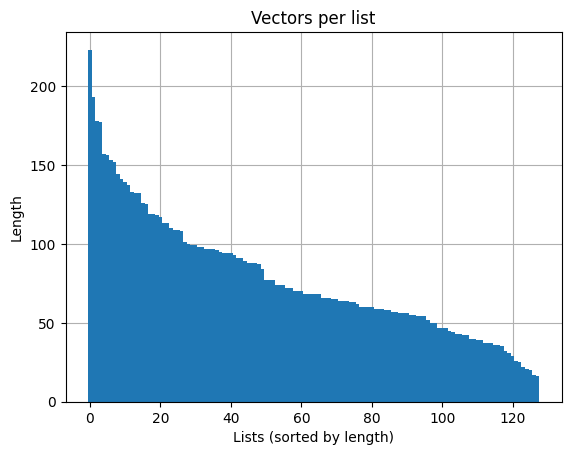

In [28]:
els_per_cluster = []
for i in range(ivf.Kp):
    els_per_cluster.append(len(ivf.ivf[i]))
fig, axs = plt.subplots(1)
axs.bar(range(ivf.Kp), sorted(els_per_cluster, reverse=True), width=1.0)
axs.set_xlabel("Lists (sorted by length)")
axs.set_ylabel("Length")
axs.set_title("Vectors per list")
axs.set_axisbelow(True)
axs.grid()

Computing the average recall at various values of R for the set of queries:

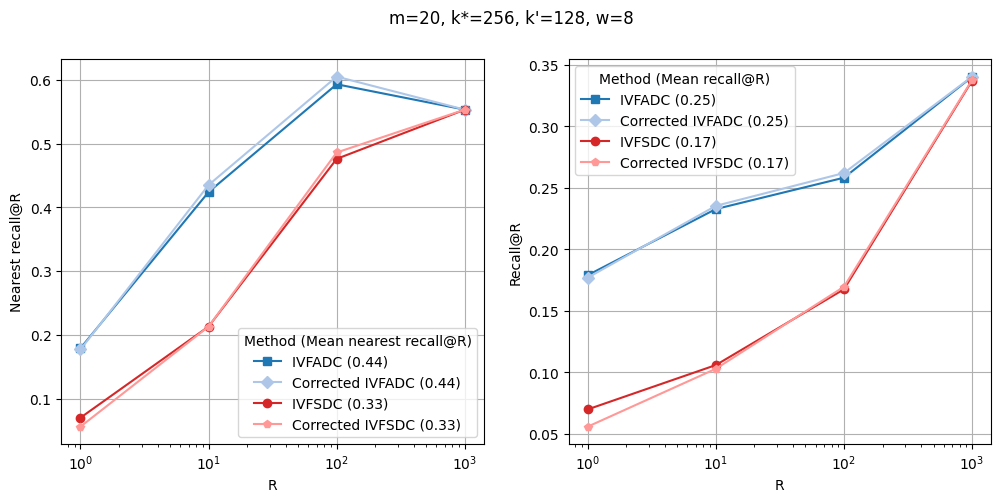

In [29]:
results_ivf = compute_recall(ivf, R, queries, exact_ranks, w=W)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_ivf["nearest_asym_recall_mean"], '-s', label=f"IVFADC ({np.nanmean(results_ivf['nearest_asym_recall_mean']):.2f})", color=tab20(0))
axs[0].plot(R, results_ivf["nearest_asym_corr_recall_mean"], '-D', label=f"Corrected IVFADC ({np.nanmean(results_ivf['nearest_asym_corr_recall_mean']):.2f})", color=tab20(1))
axs[0].plot(R, results_ivf["nearest_sym_recall_mean"], '-o', label=f"IVFSDC ({np.nanmean(results_ivf['nearest_sym_recall_mean']):.2f})", color=tab20(6))
axs[0].plot(R, results_ivf["nearest_sym_corr_recall_mean"], '-p', label=f"Corrected IVFSDC ({np.nanmean(results_ivf['nearest_sym_corr_recall_mean']):.2f})", color=tab20(7))
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title="Method (Mean nearest recall@R)")
axs[0].grid()

axs[1].plot(R, results_ivf["asym_recall_mean"], '-s', label=f"IVFADC ({np.nanmean(results_ivf['asym_recall_mean']):.2f})", color=tab20(0))
axs[1].plot(R, results_ivf["asym_corr_recall_mean"], '-D', label=f"Corrected IVFADC ({np.nanmean(results_ivf['asym_corr_recall_mean']):.2f})", color=tab20(1))
axs[1].plot(R, results_ivf["sym_recall_mean"], '-o', label=f"IVFSDC ({np.nanmean(results_ivf['sym_recall_mean']):.2f})", color=tab20(6))
axs[1].plot(R, results_ivf["sym_corr_recall_mean"], '-p', label=f"Corrected IVFSDC ({np.nanmean(results_ivf['sym_corr_recall_mean']):.2f})", color=tab20(7))
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title="Method (Mean recall@R)")
axs[1].grid()

fig.suptitle(f"m={M}, k*={K}, k'={KP}, w={W}");

Plotting the average recall at 100 of PQ with and without IVF:

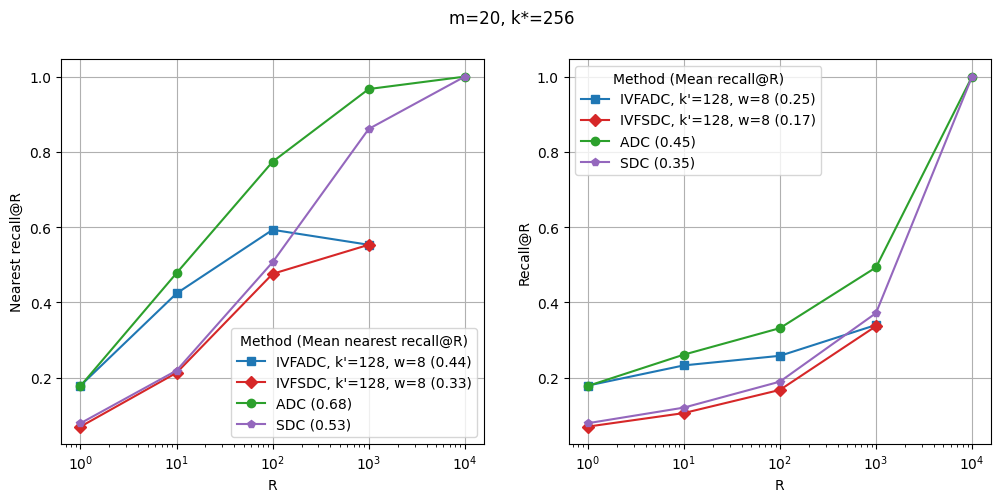

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_ivf["nearest_asym_recall_mean"], '-s', label=f"IVFADC, k'={KP}, w={W} ({np.nanmean(results_ivf['nearest_asym_recall_mean']):.2f})", color=tab20(0))
axs[0].plot(R, results_ivf["nearest_sym_recall_mean"], '-D', label=f"IVFSDC, k'={KP}, w={W} ({np.nanmean(results_ivf['nearest_sym_recall_mean']):.2f})", color=tab20(6))
axs[0].plot(R, results_pq["nearest_asym_recall_mean"], '-o', label=f"ADC ({np.nanmean(results_pq['nearest_asym_recall_mean']):.2f})", color=tab20(4))
axs[0].plot(R, results_pq["nearest_sym_recall_mean"], '-p', label=f"SDC ({np.nanmean(results_pq['nearest_sym_recall_mean']):.2f})", color=tab20(8))
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title='Method (Mean nearest recall@R)')
axs[0].grid()

axs[1].plot(R, results_ivf["asym_recall_mean"], '-s', label=f"IVFADC, k'={KP}, w={W} ({np.nanmean(results_ivf['asym_recall_mean']):.2f})", color=tab20(0))
axs[1].plot(R, results_ivf["sym_recall_mean"], '-D', label=f"IVFSDC, k'={KP}, w={W} ({np.nanmean(results_ivf['sym_recall_mean']):.2f})", color=tab20(6))
axs[1].plot(R, results_pq["asym_recall_mean"], '-o', label=f"ADC ({np.nanmean(results_pq['asym_recall_mean']):.2f})", color=tab20(4))
axs[1].plot(R, results_pq["sym_recall_mean"], '-p', label=f"SDC ({np.nanmean(results_pq['sym_recall_mean']):.2f})", color=tab20(8))
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title='Method (Mean recall@R)')
axs[1].grid()

fig.suptitle(f"m={M}, k*={K}");

With the Inverted File Index structure, curves stop at some point, as only a fraction of the database vectors are ranked.

Visualizing the average distances from the queries to the coarse centroids:

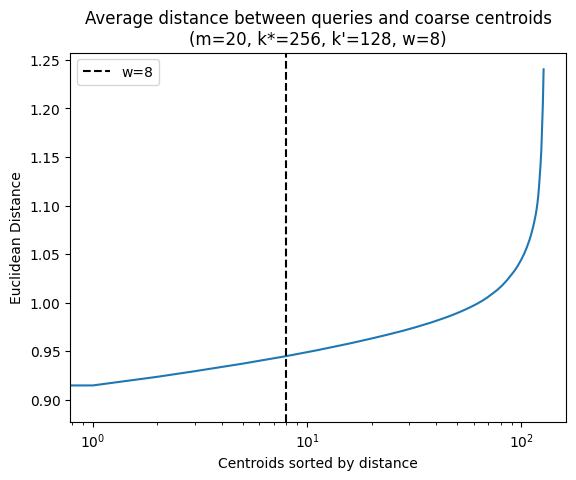

In [31]:
mean_dists2centroids = np.zeros(ivf.Kp)

for i, query in enumerate(queries):
    _, ivf_asym_rank = ivf.search(query, w=W, asym=True, correct=False)
    dist2centroids = cdist([query], ivf.centroids, 'euclidean')[0]
    sorted_dist2centroids = np.sort(dist2centroids)
    mean_dists2centroids += sorted_dist2centroids

mean_dists2centroids /= queries.shape[0]

plt.plot(mean_dists2centroids)
plt.xlabel("Centroids sorted by distance")
plt.ylabel("Euclidean Distance")
plt.axvline(x=W, color='k', linestyle='--', label=f"w={W}")
plt.xscale('log')
plt.legend()
plt.title(f"Average distance between queries and coarse centroids\n(m={M}, k*={K}, k'={KP}, w={W})");

Computing the average recall at 100 for the set of queries with different values of M, K' and w:

In [32]:
K = 256
Ms = [1, 2, 4, 10, 20] if DATASET == "glove" else [1, 2, 4, 8, 16]
Kps = [16, 128]
ws = [1, 2, 8]

ivf_training_results = []
ivf_search_results = []

for m in Ms:
    for Kp in Kps:
        print(f"Training IVF PQ with M={m}, k'={Kp}...")
        ivf = IVF(Kp=Kp, M=m, K=K, seed=RANDOM_SEED)
        start_training = time.time()
        ivf.train(tr_data, add=False)
        training_time = time.time() - start_training
        start_adding = time.time()
        ivf.add(search_data)
        adding_time = time.time() - start_adding

        code_length = int(np.log2(K)) * m
        curr_training_res = {
            "m": m, "k*": K, "k'": Kp,
            "Code length [bits]": code_length,
            "Training time [s]": training_time,
            "Adding time [s]": adding_time
        }
        ivf_training_results.append(curr_training_res)
        
        for w in ws:
            if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
                continue
            mean_search_time = 0
            nearest_recall_tr = 0
            for i, query in enumerate(queries):
                start_search = time.time()
                _, ranking = ivf.search(query, w=w, asym=True, correct=False)
                mean_search_time += (time.time() - start_search)
                if exact_ranks[i][0] in ranking[:100]:
                    nearest_recall_tr += 1
            mean_search_time /= len(queries)
            nearest_recall_tr /= len(queries)
            
            curr_search_res = {
                "m": m, "k*": K, "k'": Kp, "w": w,
                "Code length [bits]": code_length,
                "Mean search time [ms]": mean_search_time*1000,
                "Nearest recall@100": nearest_recall_tr
            }
            ivf_search_results.append(curr_search_res)

del ivf
ivf_training_results = pd.DataFrame(ivf_training_results)
ivf_search_results = pd.DataFrame(ivf_search_results)

Training IVF PQ with M=1, k'=16...
Training IVF PQ with M=1, k'=128...
Training IVF PQ with M=2, k'=16...
Training IVF PQ with M=2, k'=128...
Training IVF PQ with M=4, k'=16...
Training IVF PQ with M=4, k'=128...
Training IVF PQ with M=10, k'=16...
Training IVF PQ with M=10, k'=128...
Training IVF PQ with M=20, k'=16...
Training IVF PQ with M=20, k'=128...


Plotting the average recall at 100:

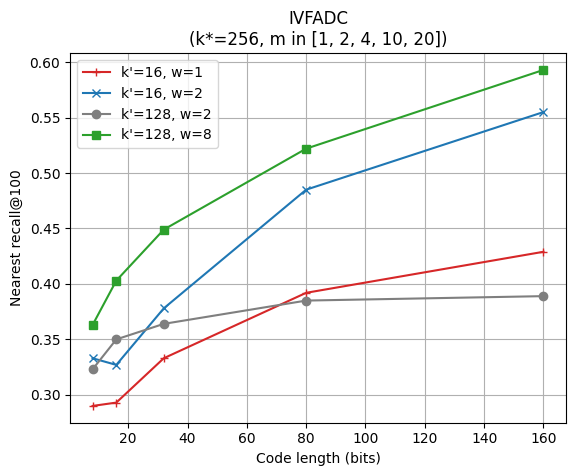

In [33]:
colors = ['tab:red', 'tab:blue', 'tab:gray', 'tab:green', 'black']
i = 0
for Kp in Kps:
    for w in ws:
        if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
            continue
        res = ivf_search_results[(ivf_search_results["k'"]==Kp) & (ivf_search_results["w"]==w)]
        plt.plot(res["Code length [bits]"], res["Nearest recall@100"], marker=markers[i], color=colors[i], label=f"k'={Kp}, w={w}")
        i += 1

plt.xlabel("Code length (bits)")
plt.ylabel("Nearest recall@100")
plt.title(f"IVFADC\n(k*={K}, m in {Ms})")
plt.legend()
plt.grid()

Nearest recall@100 strongly depends on the IVF parameters. Increasing the code length is useless if $w$ is not big enough, as the nearest neighbors which are not assigned to one of the $w$ centroids associated with the query are definitely lost.

This approach is significantly more efficient than SDC and ADC on large datasets, as it only compares the query to a small fraction of the database vectors. The proportion of the dataset to visit is roughly linear in $w/k'$.

For a fixed proportion, it is worth using higher values of $k'$, as this increases the accuracy, as shown, on the "sift" dataset, by comparing, for the tuple (k', w), the parameters (1024, 1) against (8192, 8) and (1024, 8) against (8192, 64).

Plotting the search time:

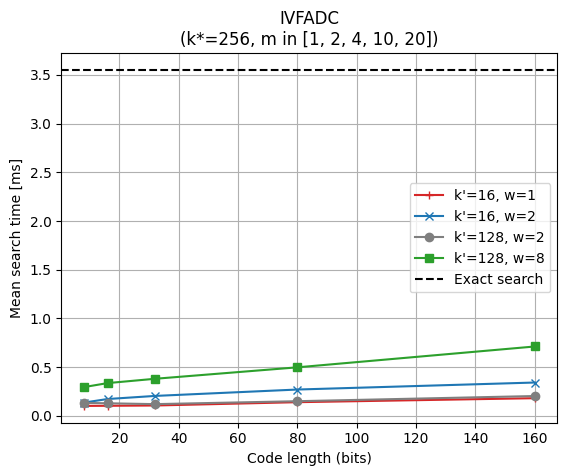

In [34]:
i = 0
for Kp in Kps:
    for w in ws:
        if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
            continue
        res = ivf_search_results[(ivf_search_results["k'"]==Kp) & (ivf_search_results["w"]==w)]
        plt.plot(res["Code length [bits]"], res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"k'={Kp}, w={w}")
        i += 1

plt.axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")
plt.xlabel("Code length (bits)")
plt.ylabel("Mean search time [ms]")
plt.title(f"IVFADC\n(k*={K}, m in {Ms})")
plt.legend()
plt.grid()

Higher values of $k'$ yield higher search efficiencies for large datasets, as the search benefits from parsing a smaller fraction of the memory. However, for small datasets, the complexity of the coarse quantizer may be the bottleneck if $k' \times D > n/k'$.

Comparing search times and average recall at 100 of PQ with and without IVF, for a fixed code length:

In [35]:
m = 10 if DATASET == "glove" else 8
search_results[(search_results["m"]==m) & (search_results["k*"]==256)].style.background_gradient(
    subset=['Mean search time [ms]', 'Nearest recall@100'],
    cmap='Blues'
)

,m,k*,Code length [bits],Asymmetric Distance,Mean search time [ms],Nearest recall@100
28,10,256,80,True,1.041344,0.586000
29,10,256,80,False,1.176089,0.306000


In [36]:
ivf_search_results[(ivf_search_results["m"]==m)].style.background_gradient(
    subset=['Mean search time [ms]', 'Nearest recall@100'],
    cmap='Blues'
)

,m,k*,k',w,Code length [bits],Mean search time [ms],Nearest recall@100
12,10,256,16,1,80,0.140501,0.392000
13,10,256,16,2,80,0.270398,0.485000
14,10,256,128,2,80,0.150544,0.385000
15,10,256,128,8,80,0.498357,0.522000


## Exploration of alternative approaches

### Product Quantization

Computing the average recall at various values of R for the set of queries on scaled data with different scaling approaches as well as the KMeans inertia (sum of squared distances of samples to their closest cluster center) in each subspace:

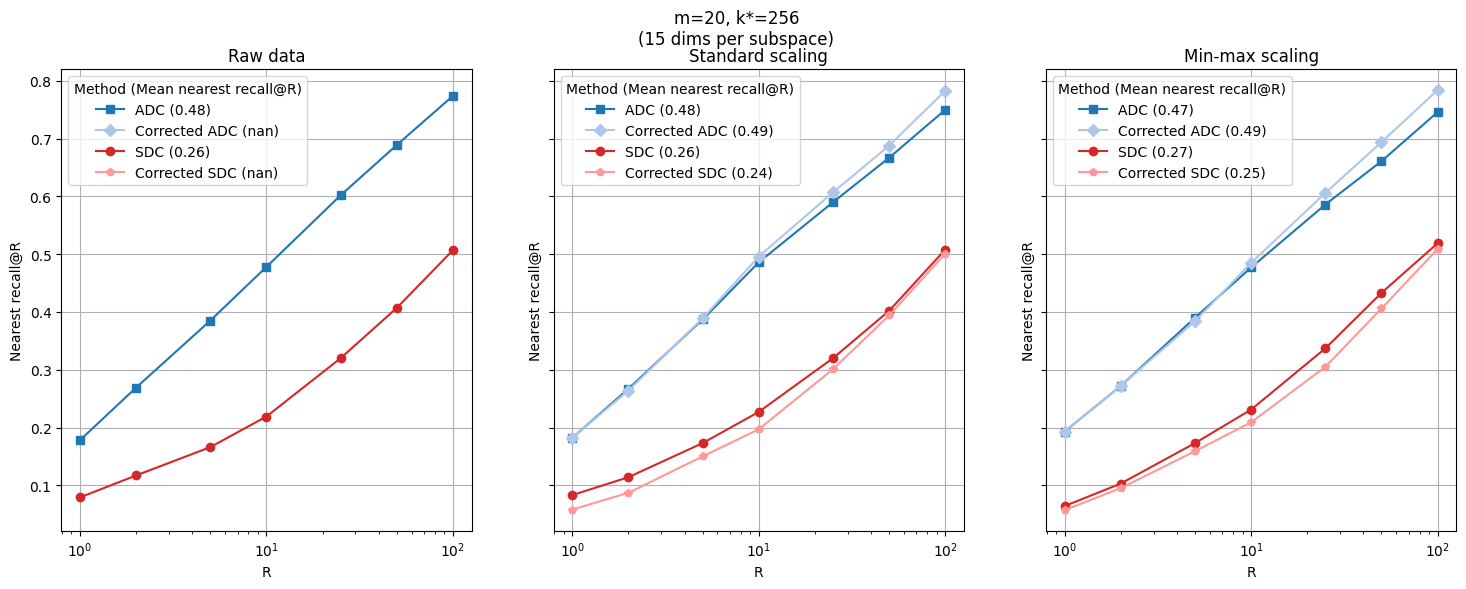

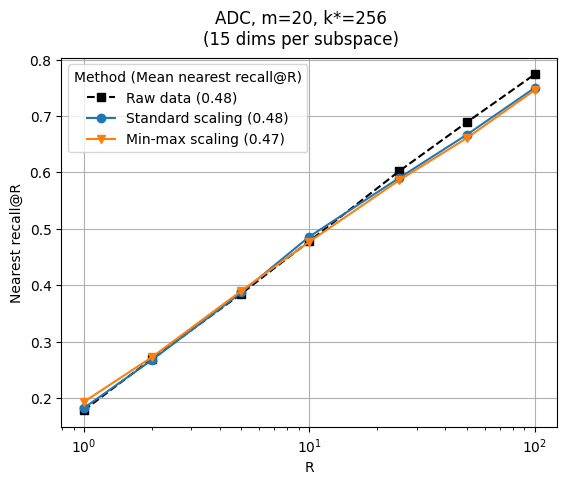

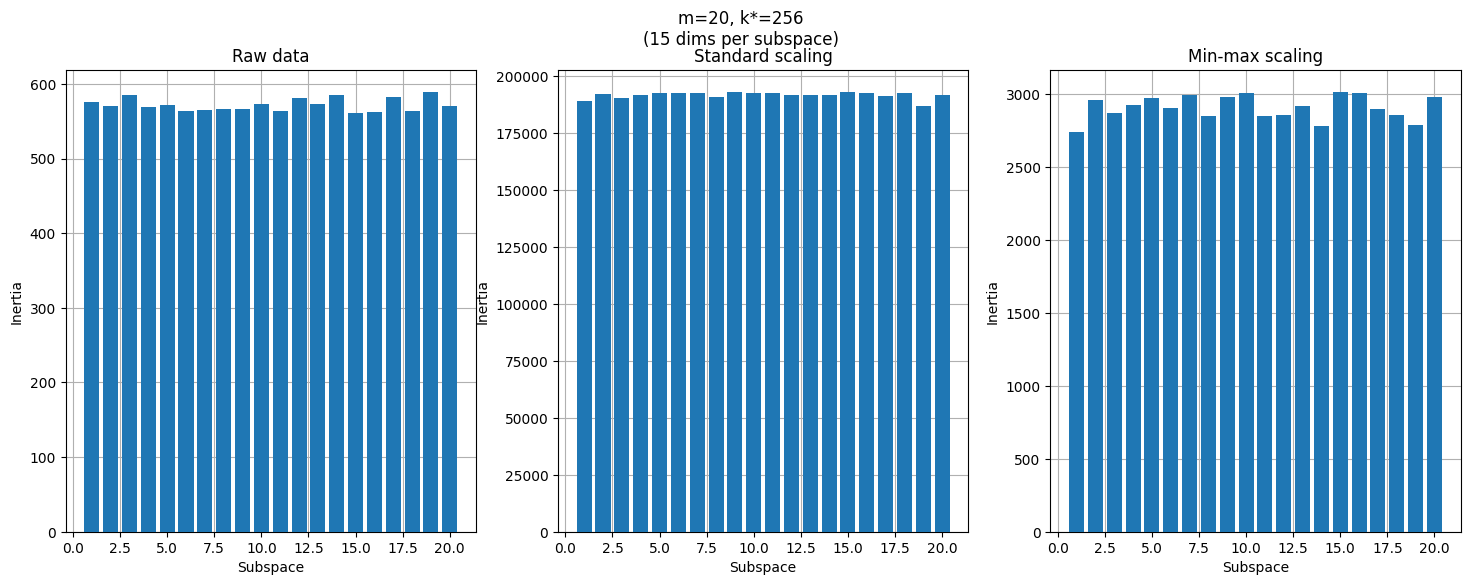

In [37]:
std_scaler = StandardScaler()
tr_data_std = std_scaler.fit_transform(tr_data)
search_data_std = std_scaler.transform(search_data)
queries_std = std_scaler.transform(queries)
es_std = ExactSearch(search_data_std)
exact_ranks_std = np.empty((queries_std.shape[0], search_data_std.shape[0]))
for i, query in enumerate(queries_std):
    _, rank = es_std.search(query)
    exact_ranks_std[i] = rank
del es_std

R_medium = [1, 2, 5, 10, 25, 50, 100]
pq = PQ(M=M, K=K, seed=RANDOM_SEED)
pq.train(tr_data, add=False, compute_distortions=True)
pq.add(search_data)
results_pq_med = compute_recall(pq, R_medium, queries, exact_ranks, correct=False, sym=True)

pq_std = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_std.train(tr_data_std, add=False)
pq_std.add(search_data_std, compute_distortions=True)
results_pq_std = compute_recall(pq_std, R_medium, queries_std, exact_ranks_std)
del pq_std

minmax_scaler = MinMaxScaler()
tr_data_minmax = minmax_scaler.fit_transform(tr_data)
search_data_minmax = minmax_scaler.transform(search_data)
queries_minmax = minmax_scaler.transform(queries)
es_minmax = ExactSearch(search_data_minmax)
exact_ranks_minmax = np.empty((queries_minmax.shape[0], search_data_minmax.shape[0]))
for i, query in enumerate(queries_minmax):
    _, rank = es_minmax.search(query)
    exact_ranks_minmax[i] = rank
del es_minmax

pq_minmax = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_minmax.train(tr_data_minmax, add=False)
pq_minmax.add(search_data_minmax, compute_distortions=True)
results_pq_minmax = compute_recall(pq_minmax, R_medium, queries_minmax, exact_ranks_minmax)
del pq_minmax

scaling_methods = [
    ("Raw data", results_pq_med),
    ("Standard scaling", results_pq_std),
    ("Min-max scaling", results_pq_minmax)
]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (title, data) in zip(axs, scaling_methods):
    ax.plot(R_medium, data["nearest_asym_recall_mean"], '-s', label=f"ADC ({np.mean(data['nearest_asym_recall_mean']):.2f})", color=tab20(0))
    ax.plot(R_medium, data["nearest_asym_corr_recall_mean"], '-D', label=f"Corrected ADC ({np.mean(data['nearest_asym_corr_recall_mean']):.2f})", color=tab20(1))
    ax.plot(R_medium, data["nearest_sym_recall_mean"], '-o', label=f"SDC ({np.mean(data['nearest_sym_recall_mean']):.2f})", color=tab20(6))
    ax.plot(R_medium, data["nearest_sym_corr_recall_mean"], '-p', label=f"Corrected SDC ({np.mean(data['nearest_sym_corr_recall_mean']):.2f})", color=tab20(7))
    ax.set_xscale('log')
    ax.set_xlabel('R')
    ax.set_ylabel('Nearest recall@R')
    ax.set_title(title)
    ax.legend(title="Method (Mean nearest recall@R)")
    ax.grid()
fig.suptitle(f"m={M}, k*={K}\n({tr_data.shape[1] // M} dims per subspace)")
plt.show()

fig, axs = plt.subplots(1)

colors = ["black", tab10(0), tab10(1)]
markers = ["--s", "-o", "-v"]
for i, (title, data) in enumerate(scaling_methods):
    axs.plot(R_medium, data["nearest_asym_recall_mean"], markers[i], label=f"{title} ({np.mean(data['nearest_asym_recall_mean']):.2f})", color=colors[i])
axs.set_xscale('log')
axs.set_xlabel('R')
axs.set_ylabel('Nearest recall@R')
axs.legend(title="Method (Mean nearest recall@R)")
axs.grid()
fig.suptitle(f"ADC, m={M}, k*={K}\n({tr_data.shape[1] // M} dims per subspace)")
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, (title, results) in zip(axs, scaling_methods):
    ax.bar(range(1, results["inertia"].shape[0]+1), results["inertia"], zorder=3)
    ax.set_xlabel('Subspace')
    ax.set_ylabel('Inertia')
    ax.set_title(title)
    ax.grid(zorder=0)
fig.suptitle(f"m={M}, k*={K}\n({tr_data.shape[1] // M} dims per subspace)")
plt.show()

Plotting the variance explained by the PCA components in each subspace:

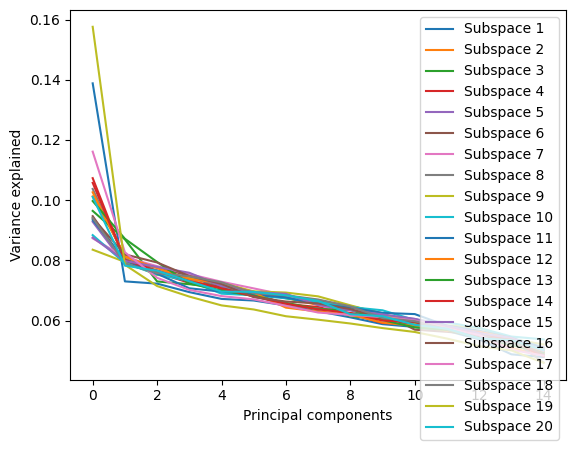

In [38]:
pq_pca = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_pca.plot_variance_explained(tr_data)

Computing the average recall at various values of R for the set of queries on PCA-reduced data, using different numbers of components and the following approaches:
- Subvectors are reduced in dimensionality, centroids are computed in this reduced space, and the reduced centroids are stored. At query time, query subvectors are also reduced before lookup. This is implemented by calling the PQ constructor with `dim_reduction=True` and specifying the number of dimensions when calling the `train` method. This approach is labelled "Subspace Red." in the figure legend.
- Subspaces are reduced in dimensionality, centroids are computed in the reduced space, but these centroids are transformed back to the original space and stored in full dimensionality. Queries are compared against the full-dimensional centroids. This is achieved by calling the PQ constructor with `dim_reduction=False` and specifying the number of dimensions when calling the `train` method. This approach is labelled "Centroids Red." in the figure legend.
- Entire vectors, rather than subspaces, are reduced in dimensionality before PQ training. This is labelled "Full Vectors Red." in the figure legend.

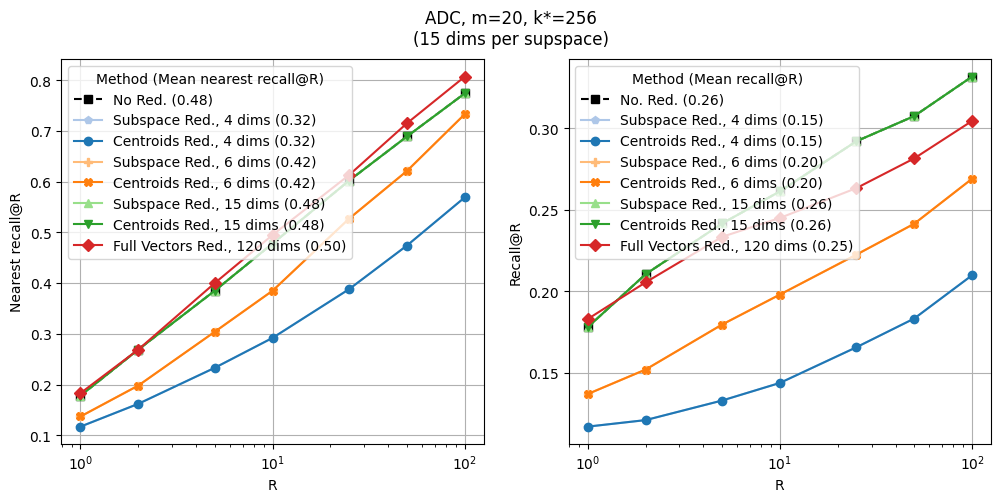

In [39]:
results_pca = {}
num_dims = [4, 6]
num_dims.append(tr_data.shape[1]//M)
for dim in num_dims:
    pq_pca = PQ(M=M, K=K, seed=RANDOM_SEED, dim_reduction=True)
    pq_pca.train(tr_data, add=False, num_dims=dim)
    pq_pca.add(search_data, compute_distortions=False)
    results_pq_pca = compute_recall(pq_pca, R_medium, queries, exact_ranks, correct=False, sym=False)
    results_pca[f"{dim}_red"] = results_pq_pca
    results_pca[f"{dim}_red"]["search_NMSE"] = NMSE(search_data, pq_pca.decompress(pq_pca.pqcode))

for dim in num_dims:
    pq_pca = PQ(M=M, K=K, seed=RANDOM_SEED, dim_reduction=False)
    pq_pca.train(tr_data, add=False, num_dims=dim)
    pq_pca.add(search_data, compute_distortions=False)
    results_pq_pca = compute_recall(pq_pca, R_medium, queries, exact_ranks, correct=False, sym=False)
    results_pca[dim] = results_pq_pca
    results_pca[dim]["search_NMSE"] = NMSE(search_data, pq_pca.decompress(pq_pca.pqcode))

n_components = M*6
pca = PCA(n_components=n_components).fit(tr_data)
tr_data_red = pca.transform(tr_data)
search_data_red = pca.transform(search_data)
queries_red = pca.transform(queries)
pq_pca = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_pca.train(tr_data_red, add=False)
pq_pca.add(search_data_red, compute_distortions=False)
results_pq_pca = compute_recall(pq_pca, R_medium, queries_red, exact_ranks, correct=False, sym=False)
results_pca["full_red"] = results_pq_pca

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R_medium, results_pq_med["nearest_asym_recall_mean"], '--s', label=f"No Red. ({np.mean(results_pq_med['nearest_asym_recall_mean']):.2f})", color="black")
for i, dim, m1, m2 in zip(range(0, len(num_dims)*2+2, 2), num_dims, ['-o', '-X', '-v'], ['-p', '-P', '-^']):
    axs[0].plot(R_medium, results_pca[f"{dim}_red"]["nearest_asym_recall_mean"], m2, label=f"Subspace Red., {dim} dims ({np.mean(results_pca[f'{dim}_red']['nearest_asym_recall_mean']):.2f})", color=tab20(i+1))
    axs[0].plot(R_medium, results_pca[dim]["nearest_asym_recall_mean"], m1, label=f"Centroids Red., {dim} dims ({np.mean(results_pca[dim]['nearest_asym_recall_mean']):.2f})", color=tab20(i))
axs[0].plot(R_medium, results_pca["full_red"]["nearest_asym_recall_mean"], '-D', label=f"Full Vectors Red., {n_components} dims ({np.mean(results_pca['full_red']['nearest_asym_recall_mean']):.2f})", color=tab20(len(num_dims)*2))
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title='Method (Mean nearest recall@R)')
axs[0].grid()

axs[1].plot(R_medium, results_pq_med["asym_recall_mean"], '--s', label=f"No. Red. ({np.mean(results_pq_med['asym_recall_mean']):.2f})", color="black")
for i, dim, m1, m2 in zip(range(0, len(num_dims)*2+2, 2), num_dims, ['-o', '-X', '-v'], ['-p', '-P', '-^']):
    axs[1].plot(R_medium, results_pca[f"{dim}_red"]["asym_recall_mean"], m2, label=f"Subspace Red., {dim} dims ({np.mean(results_pca[f'{dim}_red']['asym_recall_mean']):.2f})", color=tab20(i+1))
    axs[1].plot(R_medium, results_pca[dim]["asym_recall_mean"], m1, label=f"Centroids Red., {dim} dims ({np.mean(results_pca[dim]['asym_recall_mean']):.2f})", color=tab20(i))
axs[1].plot(R_medium, results_pca["full_red"]["asym_recall_mean"], '-D', label=f"Full Vectors Red., {n_components} dims ({np.mean(results_pca['full_red']['asym_recall_mean']):.2f})", color=tab20(len(num_dims)*2))
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title='Method (Mean recall@R)')
axs[1].grid()

fig.suptitle(f"ADC, m={M}, k*={K}\n({tr_data.shape[1]//M} dims per supspace)");

del pq_pca

Drop in recall is due to training-indexing mismatch.

Displaying NMSE on search data:

In [40]:
pca_nmse = {}
pca_nmse["No Dim. Red."] = results_pq["search_NMSE"]
for dim in num_dims:
    pca_nmse[f"Centroids Dim. Red., {dim} dims"] = results_pca[dim]["search_NMSE"]
    pca_nmse[f"Subspace Dim. Red., {dim} dims"] = results_pca[f"{dim}_red"]["search_NMSE"]

pd.DataFrame(pca_nmse, index=["NMSE on search data"]).T.style.background_gradient(cmap='Blues')

,NMSE on search data
No Dim. Red.,0.492313
"Centroids Dim. Red., 4 dims",0.631062
"Subspace Dim. Red., 4 dims",0.631062
"Centroids Dim. Red., 6 dims",0.569107
"Subspace Dim. Red., 6 dims",0.569107
"Centroids Dim. Red., 15 dims",0.492313
"Subspace Dim. Red., 15 dims",0.492313


Applying whitening to the best performing approach:

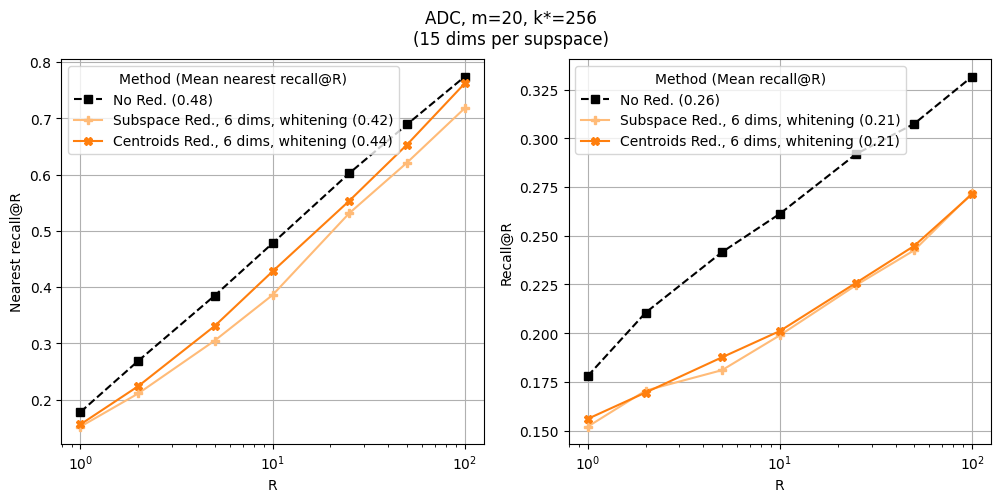

In [41]:
num_dims = 6

pq_pca = PQ(M=M, K=K, seed=RANDOM_SEED, dim_reduction=True)
pq_pca.train(tr_data, add=False, num_dims=num_dims, whiten=True)
pq_pca.add(search_data, compute_distortions=False)
results_pq_whiten_red_pca = compute_recall(pq_pca, R_medium, queries, exact_ranks, correct=False, sym=False)

pq_pca = PQ(M=M, K=K, seed=RANDOM_SEED, dim_reduction=False)
pq_pca.train(tr_data, add=False, num_dims=num_dims, whiten=True)
pq_pca.add(search_data, compute_distortions=False)
results_pq_whiten_pca = compute_recall(pq_pca, R_medium, queries, exact_ranks, correct=False, sym=False)

del pq_pca

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R_medium, results_pq_med["nearest_asym_recall_mean"], '--s', label=f"No Red. ({np.mean(results_pq_med['nearest_asym_recall_mean']):.2f})", color="black")
axs[0].plot(R_medium, results_pq_whiten_pca["nearest_asym_recall_mean"], '-P', label=f"Subspace Red., {num_dims} dims, whitening ({np.mean(results_pq_whiten_pca['nearest_asym_recall_mean']):.2f})", color=tab20(3))
axs[0].plot(R_medium, results_pq_whiten_red_pca["nearest_asym_recall_mean"], '-X', label=f"Centroids Red., {num_dims} dims, whitening ({np.mean(results_pq_whiten_red_pca['nearest_asym_recall_mean']):.2f})", color=tab20(2))

axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title='Method (Mean nearest recall@R)')
axs[0].grid()

axs[1].plot(R_medium, results_pq_med["asym_recall_mean"], '--s', label=f"No Red. ({np.mean(results_pq_med['asym_recall_mean']):.2f})", color="black")
axs[1].plot(R_medium, results_pq_whiten_pca["asym_recall_mean"], '-P', label=f"Subspace Red., {num_dims} dims, whitening ({np.mean(results_pq_whiten_pca['asym_recall_mean']):.2f})", color=tab20(3))
axs[1].plot(R_medium, results_pq_whiten_red_pca["asym_recall_mean"], '-X', label=f"Centroids Red., {num_dims} dims, whitening ({np.mean(results_pq_whiten_red_pca['asym_recall_mean']):.2f})", color=tab20(2))
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title='Method (Mean recall@R)')
axs[1].grid()

fig.suptitle(f"ADC, m={M}, k*={K}\n({tr_data.shape[1]//M} dims per supspace)");

In order to provide good quantization properties when choosing a constant value of `K`, each subvector should have, on average, a comparable inertia (sum of squared distances of samples to their closest cluster center). One way to ensure this property is to multiply the vector by a random orthogonal matrix prior to quantization. However, for most vector types, such as with SIFT descriptors, this is not required and not recommended, as consecutive components are often correlated by construction and are better quantized together with the same subquantizer. 

To perform such transformation, we need to call the constructor with `orth_transf=True`.

Evaluating the impact of orthogonalization on the search performance:

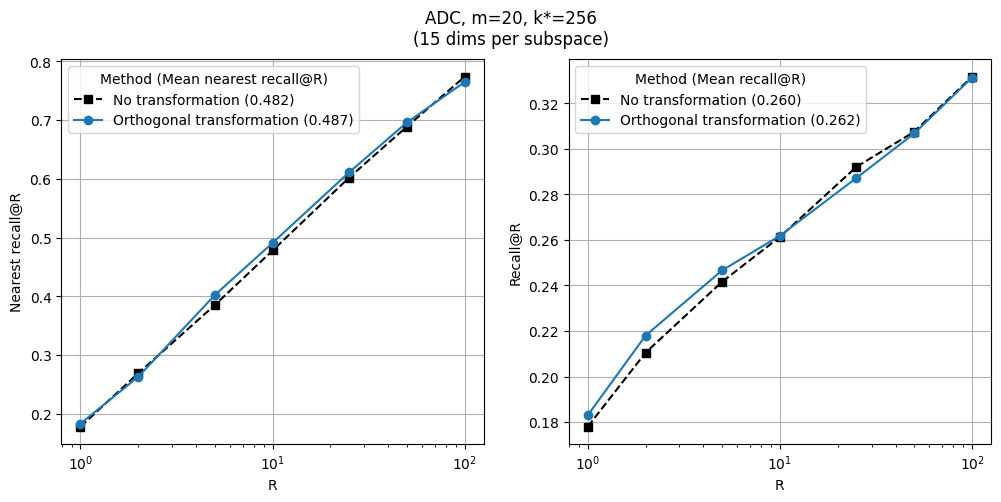

In [42]:
pq_orth = PQ(M=M, K=K, seed=RANDOM_SEED, orth_transf=True)
pq_orth.train(tr_data, add=True)
pq_orth.add(search_data, compute_distortions=False)
results_pq_orth = compute_recall(pq_orth, R_medium, queries, exact_ranks, correct=False, sym=False)
results_pq_orth["search_NMSE"] = NMSE(search_data, pq_orth.decompress(pq_orth.pqcode))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R_medium, results_pq_med["nearest_asym_recall_mean"], '--s', label=f"No transformation ({np.mean(results_pq_med['nearest_asym_recall_mean']):.3f})", color='black')
axs[0].plot(R_medium, results_pq_orth["nearest_asym_recall_mean"], '-o', label=f"Orthogonal transformation ({np.mean(results_pq_orth['nearest_asym_recall_mean']):.3f})")
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title='Method (Mean nearest recall@R)')
axs[0].grid()

axs[1].plot(R_medium, results_pq_med["asym_recall_mean"], '--s', label=f"No transformation ({np.mean(results_pq_med['asym_recall_mean']):.3f})", color='black')
axs[1].plot(R_medium, results_pq_orth["asym_recall_mean"], '-o', label=f"Orthogonal transformation ({np.mean(results_pq_orth['asym_recall_mean']):.3f})")
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title='Method (Mean recall@R)')
axs[1].grid()

fig.suptitle(f"ADC, m={M}, k*={K}\n({tr_data.shape[1] // M} dims per subspace)");

Displaying NMSE on search data:

In [43]:
pd.DataFrame(
    [results_pq, results_pq_orth,],
    index=["No transformation", "Orthogonal transformation"]
)[["search_NMSE"]].style.background_gradient(cmap='Blues')

,search_NMSE
No transformation,0.492313
Orthogonal transformation,0.493669


Visualizing KMeans inertia in each subspace:

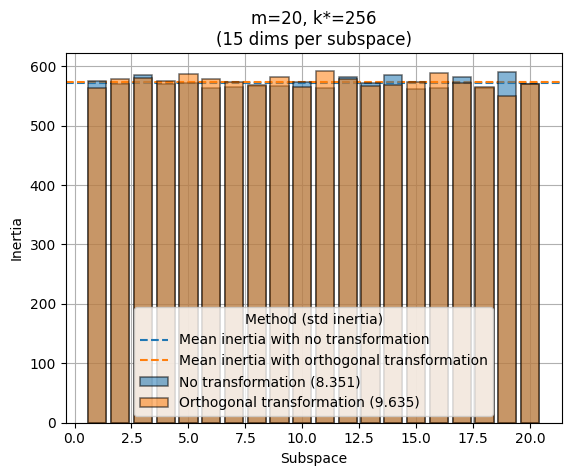

In [44]:
fig, axs = plt.subplots(1)

axs.bar(range(1, results_pq["inertia"].shape[0]+1), results_pq["inertia"],
        zorder=3, edgecolor='black', linewidth=1.1, alpha=0.55, label=f"No transformation ({np.std(results_pq['inertia']):.3f})")
axs.bar(range(1, results_pq_orth["inertia"].shape[0]+1), results_pq_orth["inertia"],
        zorder=3, edgecolor='black', linewidth=1.1, alpha=0.55, label=f"Orthogonal transformation ({np.std(results_pq_orth['inertia']):.3f})")
plt.axhline(np.mean(results_pq["inertia"]), linestyle='--', label="Mean inertia with no transformation", color=tab10(0))
plt.axhline(np.mean(results_pq_orth["inertia"]), linestyle='--', label="Mean inertia with orthogonal transformation", color=tab10(1))
axs.set_xlabel('Subspace')
axs.set_ylabel('Inertia')
axs.grid(zorder=0)
axs.legend(loc='lower center', title="Method (std inertia)")
axs.set_title(f"m={M}, k*={K}\n({tr_data.shape[1] // M} dims per subspace)");

del pq_orth

We will explore the following criteria for grouping components into subspaces:
1. Agglomerative Hierarchical clustering of features based on their euclidean distance with different linkage criteria.
2. Agglomerative Hierarchical clustering of features based on inverse correlation (absolute value of pearson correlation) with different linkage criteria.
3. KMeans clustering of features.
4. Constrained KMeans clustering of features, where the clusters have equal size.
5. Spectral Biclustering of the data (clusters vectors and features simultaneously).

Criteria 1., 3., 4. and 5. group similar features together (according to a distance metric), while criterion 2. groups features that are not correlated together.

Note that, except for criterion 4., the resulting partitions are not necessarily equal in size.

Performing agglomerative hierarchical clustering of features with different linkage criteria:

In [45]:
clusters_info = {}
clusters_info['method'] = []
clusters_info['labels'] = []
clusters_info['clusters_sizes'] = []
clusters_info['silhouette'] = []

dist_mat = pdist(tr_data.T, metric='euclidean')

algorithms = ["single", "complete", "average", "ward"]
for algorithm in algorithms:
    linkage_res = linkage(dist_mat, method=algorithm, metric='euclidean', optimal_ordering=False)
    clusters = fcluster(linkage_res, t=M, criterion='maxclust')
    counts = np.bincount(clusters)
    silhouette = silhouette_score(squareform(dist_mat), clusters, metric='precomputed')
    clusters_info['method'].append(algorithm)
    clusters_info['labels'].append(clusters)
    clusters_info['clusters_sizes'].append(counts[counts!=0])
    clusters_info['silhouette'].append(silhouette)

clusters_info_df = pd.DataFrame(clusters_info)
clusters_info_df[[
        'method', 'clusters_sizes', 'silhouette'
    ]].style.background_gradient(cmap='Blues', subset=['silhouette'])

,method,clusters_sizes,silhouette
0,single,[ 1 1 280 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1],-0.016754
1,complete,[ 2 10 2 1 7 1 1 21 19 9 28 6 9 2 40 38 13 33 32 26],0.002502
2,average,[ 1 1 6 1 2 1 20 2 3 146 1 2 92 11 1 1 6 1 1 1],0.007290
3,ward,[ 7 1 8 43 15 17 2 3 10 17 17 19 24 8 26 29 12 11 11 20],0.005514


Selecting the best clustering:

In [46]:
if DATASET == "siftsmall":
    hier_dist_labels = clusters_info_df[clusters_info_df['method']=='complete']['labels'].values[0]
elif DATASET == "glove":
    hier_dist_labels = clusters_info_df[clusters_info_df['method']=='ward']['labels'].values[0]
else:
    hier_dist_labels = clusters_info_df[clusters_info_df['method']=='ward']['labels'].values[0]

Grouping features by running Constrained KMeans, KMeans and Spectral Biclustering:

In [47]:
clusters_size = tr_data.shape[1] // M
km_const = KMeansConstrained(n_clusters=M, size_min=clusters_size, size_max=clusters_size, random_state=RANDOM_SEED).fit(tr_data.T)
km_const_labels = km_const.labels_

km = KMeans(n_clusters=M, n_init=1, random_state=RANDOM_SEED).fit(tr_data.T)
km_labels = km.labels_

sbc = SpectralBiclustering(n_clusters=(K, M), n_init=1, random_state=RANDOM_SEED).fit(tr_data)
sbc_labels = sbc.column_labels_

partitioning_labels = {
    "Hierarchical": hier_dist_labels,
    "K-Means Equal": km_const_labels,
    "K-Means": km_labels,
    "Spectral Bi-Clustering": sbc_labels
}

Evaluating the impact of different component grouping strategies on the search performance:

Running PQ with 'Hierarchical' partitioning approach
Running PQ with 'K-Means Equal' partitioning approach
Running PQ with 'K-Means' partitioning approach
Running PQ with 'Spectral Bi-Clustering' partitioning approach


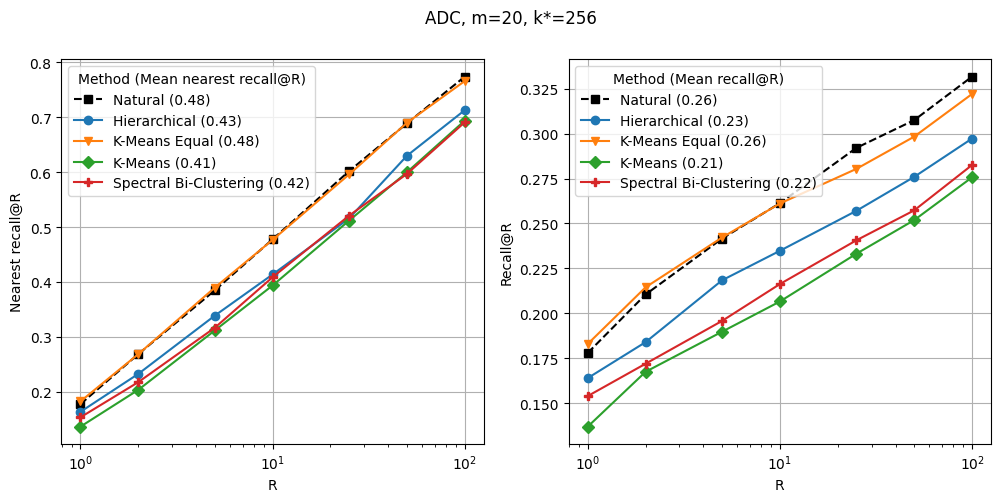

In [48]:
partitioning_results = {}
for approach, labels in partitioning_labels.items():
    print(f"Running PQ with '{approach}' partitioning approach")
    pq_opt_part = PQ(M=len(np.unique(labels)), K=K, seed=RANDOM_SEED)
    pq_opt_part.train(tr_data, add=True, features_labels=labels)
    pq_opt_part.add(search_data, compute_distortions=False)
    results_pq_opt_part = compute_recall(pq_opt_part, R_medium, queries, exact_ranks, correct=False, sym=False)
    results_pq_opt_part["search_NMSE"] = NMSE(search_data, pq_opt_part.decompress(pq_opt_part.pqcode))
    results_pq_opt_part["cluster_sizes"] = pq_opt_part.features_cluster_sizes
    partitioning_results[approach] = results_pq_opt_part
del pq_opt_part

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R_medium, results_pq_med["nearest_asym_recall_mean"], '--s', label=f"Natural ({np.mean(results_pq_med['nearest_asym_recall_mean']):.2f})", color="black")
for (approach, results), marker in zip(partitioning_results.items(), ['-o', '-v', '-D', '-P']):
    axs[0].plot(R_medium, results["nearest_asym_recall_mean"], marker, label=f"{approach} ({np.mean(results['nearest_asym_recall_mean']):.2f})")
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title='Method (Mean nearest recall@R)')
axs[0].grid()

axs[1].plot(R_medium, results_pq_med["asym_recall_mean"], '--s', label=f"Natural ({np.mean(results_pq_med['asym_recall_mean']):.2f})", color="black")
for (approach, results), marker in zip(partitioning_results.items(), ['-o', '-v', '-D', '-P']):
    axs[1].plot(R_medium, results["asym_recall_mean"], marker, label=f"{approach} ({np.mean(results['asym_recall_mean']):.2f})")
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title='Method (Mean recall@R)')
axs[1].grid()

fig.suptitle(f"ADC, m={M}, k*={K}");

Displaying NMSE on search data:

In [49]:
partitioning_results["Natual partitioning"] = results_pq
results_pq["cluster_sizes"] = clusters_size
pd.DataFrame(partitioning_results.values(), index=partitioning_results.keys()
)[["search_NMSE"]].style.background_gradient(cmap='Blues')

,search_NMSE
Hierarchical,0.527922
K-Means Equal,0.488762
K-Means,0.566364
Spectral Bi-Clustering,0.544157
Natual partitioning,0.492313


Comparing the resulting feature clusters:

In [50]:
labels_list = []
labels_names = []
for approach, labels in partitioning_labels.items():
    if approach != "Hier. Inv. Corr.":
        labels_list.append(labels.tolist())
        labels_names.append(approach)
sankey_plot(labels_list, labels_names, title="Column clusters comparison")

Visualizing KMeans inertia and the number of features in each subspace:

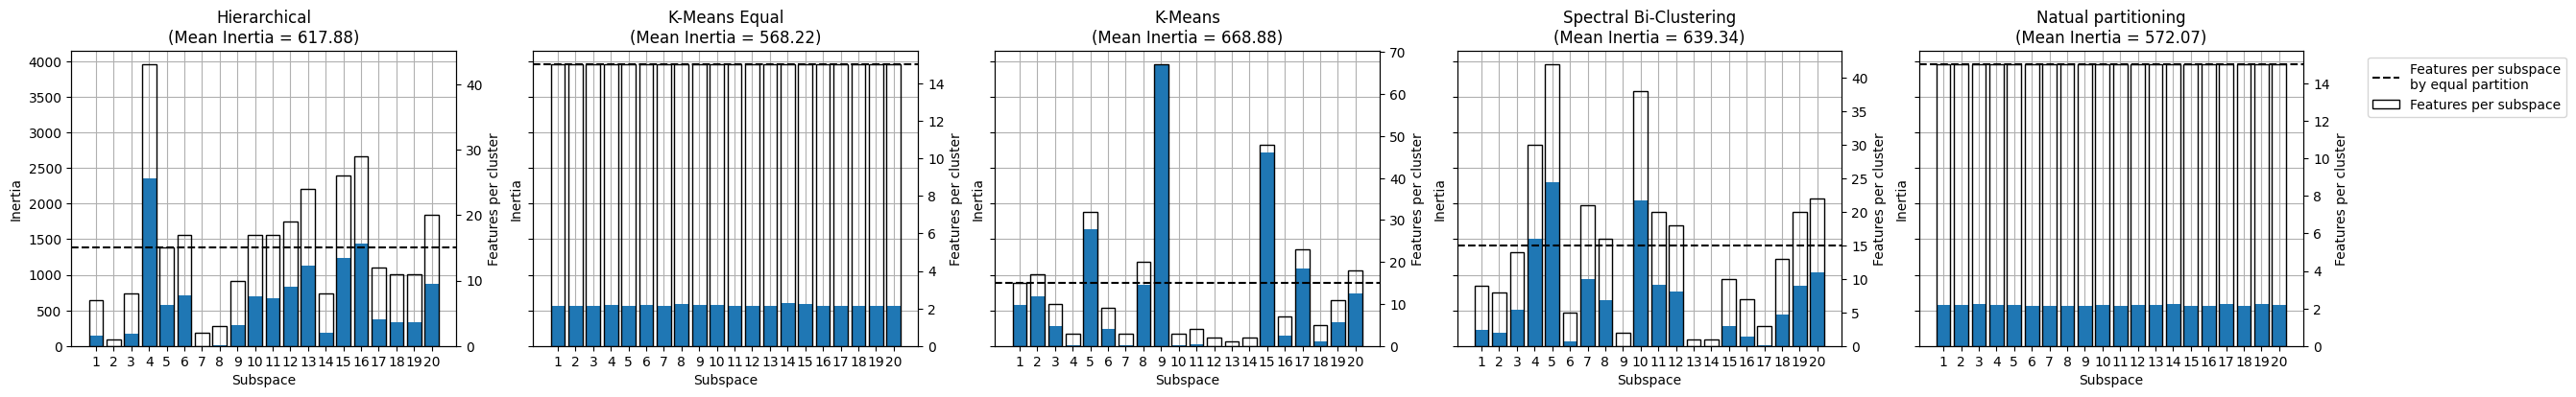

In [51]:
fig, axs = plt.subplots(1, 5, figsize=(6*5, 4), sharey=True)

equal_partition_line = int(tr_data.shape[1] / M)

for i, (approach, results) in enumerate(partitioning_results.items()):
    xticks_range = range(1, len(results["inertia"]) + 1)

    axs[i].bar(xticks_range, results["inertia"], zorder=3, label=approach)
    axs[i].set_xlabel("Subspace")
    axs[i].set_ylabel("Inertia")
    axs[i].set_title(approach+f"\n(Mean Inertia = {np.mean(results['inertia']):.2f})")
    if DATASET != "gist":
        axs[i].set_xticks(xticks_range)
    axs[i].grid(zorder=0)

    ax_twin = axs[i].twinx()
    ax_twin.bar(
        xticks_range, results["cluster_sizes"],
        zorder=3, facecolor="none", edgecolor="black", label="Features per subspace"
    )
    ax_twin.axhline(
        equal_partition_line, color="black", linestyle="--",
        label="Features per subspace\nby equal partition"
    )
    ax_twin.set_ylabel("Features per cluster")
    if i==4:
        ax_twin.legend(loc="upper right", bbox_to_anchor=(1.7, 1))

Plotting the n-th nearest neighbor distances of the vectors in the training data for different values of n:

In [52]:
if DATASET == "siftsmall":
    pq_weighted = PQ(M=M, K=K, seed=RANDOM_SEED)

    fig, axs = plt.subplots(1, 4, figsize=(16, 5))
    pq_weighted.plot_neighbor_distances(data=tr_data, neighbor=3, ax=axs[0])
    pq_weighted.plot_neighbor_distances(data=tr_data, neighbor=5, ax=axs[1])
    pq_weighted.plot_neighbor_distances(data=tr_data, neighbor=7, ax=axs[2])
    pq_weighted.plot_neighbor_distances(data=tr_data, neighbor=9, ax=axs[3])
    fig.tight_layout()

We assess the effect of weighting samples during KMeans training by considering their distance to the nth-nearest neighbor exploring various values of n and weighting strategies. The nth-nearest neighbor distance serves as a measure of local data density. By assigning weights inversely proportional to this distance, we prioritize points that are more representative of the dataset. On the other hand, assigning weights directly proportional to the nth-nearest neighbor distance prioritizes points that are more spread out, preventing overfitting in regions with a high density of data.

This is implemented by calling the `train` method with `weight_samples=True` and specifying the number of neighbors (`neighbor` parameter), the weighting method (`weight_method` parameter) and whether to use inverse weights (`inverse_weights` parameter).

The following weighting methods are considered:
- with `inverse_weights=True`:
    - when `weight_method='normal'`, weights are 1 - distances normalized to [0, 1]
    - when `weight_method='reciprocal'`, weights are 1 / distances, subsequently normalized to [0, 1] 
- with `inverse_weights=False`:
    - weights are distances normalized to [0, 1], independently of the weighting method

In [53]:
def compute_weighted_PQ_recall(
    pq, weight_samples, neighbor, inverse_weights, weight_method, R, tr_data,
    search_data, queries, exact_ranks):
    pq.train(
        tr_data, add=False, weight_samples=weight_samples,
        neighbor=neighbor, inverse_weights=inverse_weights,
        weight_method=weight_method)
    pq.add(search_data, compute_distortions=False)
    results = compute_recall(pq, R, queries, exact_ranks, correct=False, sym=False)
    decompressed_search = pq.decompress(pq.pqcode)
    error_search = NMSE(search_data, decompressed_search)
    results["search_NMSE"] = error_search
    return results

if DATASET == "siftsmall":
    neighbors = [3, 5, 7, 9]
    weight_methods = ["normal", "reciprocal"]
    inverse_weights_opts = [True, False]

    search_NMSE_weighted = []
    nearest_recall_weithed = []
    recall_weighted = []
    for neighbor in neighbors:
        for weight_method in weight_methods:
            for inverse_weights in inverse_weights_opts:
                if (weight_method == "reciprocal" and inverse_weights == False):
                    continue
                results = compute_weighted_PQ_recall(
                    pq_weighted, True, neighbor, inverse_weights, weight_method,
                    R_small, tr_data, search_data, queries, exact_ranks)
                keys = {"neighbor": neighbor, "weight_method": weight_method, "inverse_weights": inverse_weights}
                search_NMSE_weighted.append({**keys, "search_NMSE": results["search_NMSE"]})
                nearest_recall_weithed.append({**keys, "nearest_asym_recall_mean": results["nearest_asym_recall_mean"]})
                recall_weighted.append({**keys, "asym_recall_mean": results["asym_recall_mean"]})
    del pq_weighted

Plotting the results:

In [54]:
if DATASET == "siftsmall":
    nearest_recall_weithed_df = pd.DataFrame(nearest_recall_weithed)
    recall_weithed_df = pd.DataFrame(recall_weighted)

    fig, axs = plt.subplots(1, 3, figsize=(22, 5), sharey=True)
    markers = ['o', 'v', 'D', 'P']
    i=0
    for inverse_weights in inverse_weights_opts:
        for weight_method in weight_methods:
            if (weight_method == "reciprocal" and inverse_weights == False):
                continue
            axs[i].plot(R_small, results_pq_seeds[0]["nearest_asym_recall_mean"], label=f"None ({np.mean(results_pq_seeds[0]['nearest_asym_recall_mean']):.2f})", linestyle='--', marker='s', color="black")
            for j, neighbor in enumerate(neighbors):
                recall = nearest_recall_weithed_df[
                    (nearest_recall_weithed_df['neighbor']==neighbor) &
                    (nearest_recall_weithed_df['weight_method']==weight_method) &
                    (nearest_recall_weithed_df['inverse_weights']==inverse_weights)
                ]['nearest_asym_recall_mean'].values[0]
                axs[i].plot(R_small, recall, label=f"{neighbor} ({np.mean(recall):.2f})", marker=markers[j])
            axs[i].set_xlabel('R')
            axs[i].set_ylabel('Nearest recall@R')
            if weight_method == "normal" and inverse_weights == True:
                title = r"$w(i)=1-\frac{d_{n-th}(i)}{\max_j\:d_{n-th}(j)}$"
            elif weight_method == "normal" and inverse_weights == False:
                title = r"$\frac{d_{n-th}(i)}{\max_j\:d_{n-th}(j)}$"
            else:
                title = r"$w(i)=\frac{\frac{1}{d_{n-th}(i)}}{\max_j\:\frac{1}{d_{n-th}(j)}}$"
            axs[i].title.set_text(title)
            axs[i].legend(title='n (Mean nearest recall@R)')
            axs[i].grid()
            i+=1
    fig.suptitle(f"ADC, m={M}, k*={K}\n({tr_data.shape[1] // M} dims per subspace)");
    fig.tight_layout()

    fig, axs = plt.subplots(1, 3, figsize=(22, 5), sharey=True)
    markers = ['o', 'v', 'D', 'P']
    i=0
    for inverse_weights in inverse_weights_opts:
        for weight_method in weight_methods:
            if (weight_method == "reciprocal" and inverse_weights == False):
                continue
            axs[i].plot(R_small, results_pq_seeds[0]["asym_recall_mean"], label=f"None ({np.mean(results_pq_seeds[0]['asym_recall_mean']):.2f})", linestyle='--', marker='s', color="black")
            for j, neighbor in enumerate(neighbors):
                recall = recall_weithed_df[
                        (nearest_recall_weithed_df['neighbor']==neighbor) &
                        (nearest_recall_weithed_df['weight_method']==weight_method) &
                        (nearest_recall_weithed_df['inverse_weights']==inverse_weights)
                    ]['asym_recall_mean'].values[0]
                axs[i].plot(R_small, recall, label=f"{neighbor} ({np.mean(recall):.2f})", marker=markers[j])
            axs[i].set_xlabel('R')
            axs[i].set_ylabel('Recall@R')
            if weight_method == "normal" and inverse_weights == True:
                title = r"$w(i)=1-\frac{d_{n-th}(i)}{\max_j\:d_{n-th}(j)}$"
            elif weight_method == "normal" and inverse_weights == False:
                title = r"$\frac{d_{n-th}(i)}{\max_j\:d_{n-th}(j)}$"
            else:
                title = r"$w(i)=\frac{\frac{1}{d_{n-th}(i)}}{\max_j\:\frac{1}{d_{n-th}(j)}}$"
            axs[i].title.set_text(title)
            axs[i].legend(title='n (Mean recall@R)')
            axs[i].grid()
            i+=1
    fig.suptitle(f"ADC, m={M}, k*={K}\n({tr_data.shape[1] // M} dims per subspace)");
    fig.tight_layout()

Displaying NMSE on search data:

In [55]:
if DATASET == "siftsmall":
    pd.DataFrame(search_NMSE_weighted).style.background_gradient(subset=["search_NMSE"], cmap='Blues')

We use the approach introduced by Tibshirani et al. in "Diagnosis of multiple cancer types by shrunken centroids of gene expression" to modify the centroids identified by the KMeans algorithm. The value of each feature for each centroid is divided by the within-centroid variance of that feature. The feature values are then reduced by shrink_threshold. Most notably, if a particular feature value crosses zero, it is set to zero. In effect, this removes the feature from affecting the classification. This is useful, for example, for removing noisy features.

This feature is implemented by calling the constructor and specifying the parameter `shrink_threshold`. We used the [sklearn implementation of the method](https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.NearestCentroid.html#nearestcentroid).


Fitting PQ with different shrinkage thresholds:

In [56]:
codebooks = {}

codebooks["Shrink threshold = None"] = pq.codebook
del pq

thresholds = [0.5, 0.75, 1] if DATASET == "siftsmall" else [0.1, 0.25, 0.5]
shrunken_pqs = []
shrunkes_results = []

for threshold in thresholds:
    pq = PQ(M=M, K=K, seed=RANDOM_SEED, shrink_threshold=threshold)
    start_training = time.time()
    pq.train(tr_data, add=False)
    training_time = time.time() - start_training
    codebooks[f"Shrink threshold = {threshold:.2f}"] = pq.codebook

    start_adding = time.time()
    pq.add(search_data, compute_distortions=True)
    adding_time = time.time() - start_adding

    decompressed_search = pq.decompress(pq.pqcode)
    error_search = NMSE(search_data, decompressed_search)

    compressed_tr = pq.compress(tr_data)
    decompressed_tr = pq.decompress(compressed_tr)
    error_tr = NMSE(tr_data, decompressed_tr)

    shrunken_pqs.append(pq)
    shrunkes_results.append({
        "Training time [s]": training_time, "Adding time [s]": adding_time,
        "NMSE on training data": error_tr, "NMSE on search data": error_search
    })

shrunken_pq_results_df = pd.DataFrame(
    shrunkes_results,
    index=[f"Shrunken PQ, shrink_threshold={threshold:.2f}" for threshold in thresholds]
)

pq_results_df.drop(
    columns=["Compressed data shape", "Compressed data size [bytes]",
    "Original data size [bytes]", "Compression factor"],
    inplace=True)

pd.concat([pq_results_df, shrunken_pq_results_df], axis=0).style.background_gradient(cmap="Blues")

,Training time [s],Adding time [s],NMSE on training data,NMSE on search data
PQ without average distortion,8.125867,0.083142,0.457657,0.492313
PQ with average distortion,7.749209,0.253702,0.457657,0.492313
"Shrunken PQ, shrink_threshold=0.10",8.130927,0.227228,0.457836,0.491840
"Shrunken PQ, shrink_threshold=0.25",8.056974,0.225975,0.458736,0.491604
"Shrunken PQ, shrink_threshold=0.50",8.174624,0.225667,0.461712,0.492431


Plotting subspace centroids with different shrinkage thresholds:

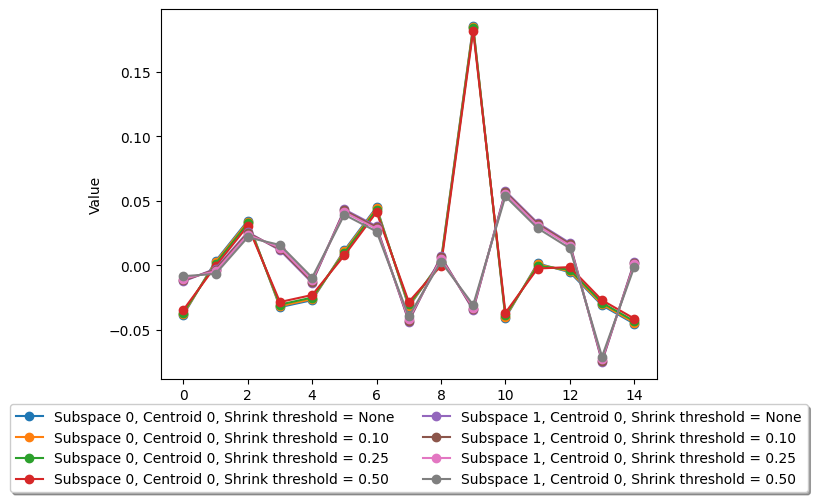

In [57]:
for method, codebook in codebooks.items():
    plt.plot(codebook[0][0], '-o', label=f"Subspace 0, Centroid 0, {method}")

for method, codebook in codebooks.items():
    plt.plot(codebook[0][1], '-o', label=f"Subspace 1, Centroid 0, {method}")

plt.xlabel('Feature')
plt.ylabel('Value')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2);

Evaluating the impact of the shrinkage threshold on the search performance:

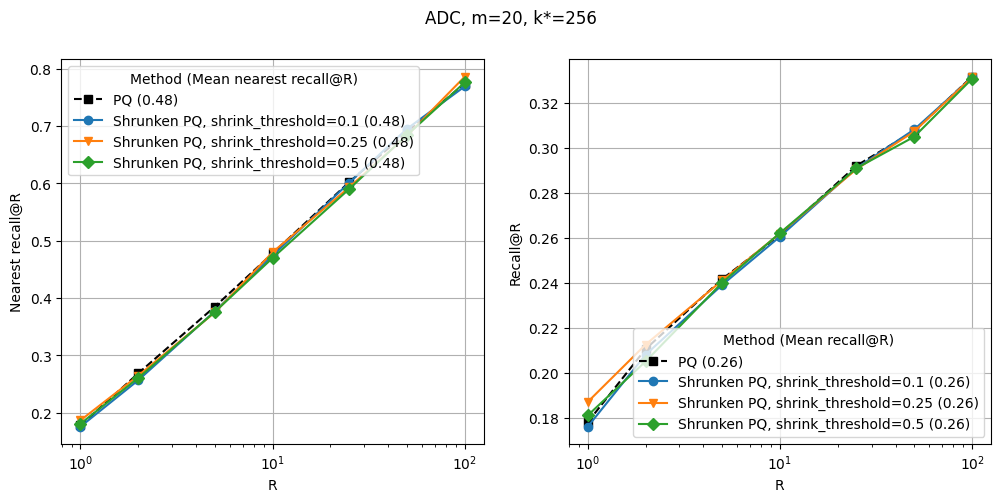

In [58]:
shrunken_recalls = {}
for i, threshold in enumerate(thresholds):
    shrunken_recalls[threshold] = compute_recall(shrunken_pqs[i], R_medium, queries, exact_ranks, correct=False, sym=False)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R_medium, results_pq_med["nearest_asym_recall_mean"], '--s', label=f"PQ ({np.mean(results_pq_med['nearest_asym_recall_mean']):.2f})", color="black")
for i, (threshold, m) in enumerate(zip(thresholds, ['-o', '-v', '-D', '-P'])):
    axs[0].plot(R_medium, shrunken_recalls[threshold]["nearest_asym_recall_mean"], m, label=f"Shrunken PQ, shrink_threshold={threshold} ({np.mean(shrunken_recalls[threshold]['nearest_asym_recall_mean']):.2f})")
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title='Method (Mean nearest recall@R)')
axs[0].grid()

axs[1].plot(R_medium, results_pq_med["asym_recall_mean"], '--s', label=f"PQ ({np.mean(results_pq_med['asym_recall_mean']):.2f})", color="black")
for i, (threshold, m) in enumerate(zip(thresholds, ['-o', '-v', '-D', '-P'])):
    axs[1].plot(R_medium, shrunken_recalls[threshold]["asym_recall_mean"], m, label=f"Shrunken PQ, shrink_threshold={threshold} ({np.mean(shrunken_recalls[threshold]['asym_recall_mean']):.2f})")
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title='Method (Mean recall@R)')
axs[1].grid()

fig.suptitle(f"ADC, m={M}, k*={K}");

### Product Quantization with InVerted File index (IVF)

Computing the average recall at various values of R for the set of queries on scaled data with different scaling approaches. Here, KMeans inertia (sum of squared distances of samples to their closest cluster center) is computed for the coarse clustering.

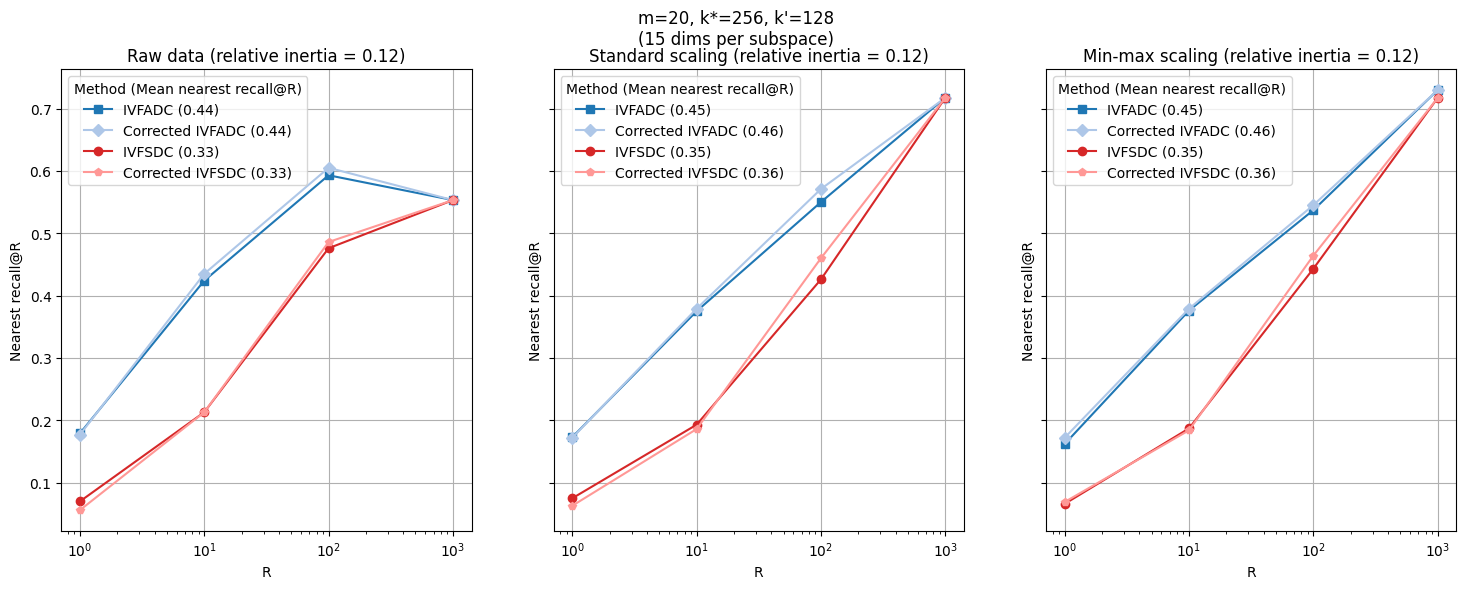

In [59]:
ivf_std = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
ivf_std.train(tr_data_std, add=False)
ivf_std.add(search_data_std, compute_distortions=True)
results_ivf_std = compute_recall(ivf_std, R, queries_std, exact_ranks_std, w=W)
del ivf_std

ivf_minmax = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
ivf_minmax.train(tr_data_minmax, add=False)
ivf_minmax.add(search_data_minmax, compute_distortions=True)
results_ivf_minmax = compute_recall(ivf_minmax, R, queries_minmax, exact_ranks_minmax, w=W)
del ivf_minmax

def compute_overall_inertia(data):
    mean = np.mean(data, axis=0)
    return np.sum(np.square(data - mean))

overall_inertia = compute_overall_inertia(tr_data)
overall_inertia_std = compute_overall_inertia(tr_data_std)
overall_inertia_minmax = compute_overall_inertia(tr_data_minmax)

scaling_methods_ivf = [
    ("Raw data", results_ivf, overall_inertia),
    ("Standard scaling", results_ivf_std, overall_inertia_std),
    ("Min-max scaling", results_ivf_minmax, overall_inertia_minmax)
]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (title, data, overall_inertia) in zip(axs, scaling_methods_ivf):
    ax.plot(R, data["nearest_asym_recall_mean"], '-s', label=f"IVFADC ({np.nanmean(data['nearest_asym_recall_mean']):.2f})", color=tab20(0))
    ax.plot(R, data["nearest_asym_corr_recall_mean"], '-D', label=f"Corrected IVFADC ({np.nanmean(data['nearest_asym_corr_recall_mean']):.2f})", color=tab20(1))
    ax.plot(R, data["nearest_sym_recall_mean"], '-o', label=f"IVFSDC ({np.nanmean(data['nearest_sym_recall_mean']):.2f})", color=tab20(6))
    ax.plot(R, data["nearest_sym_corr_recall_mean"], '-p', label=f"Corrected IVFSDC ({np.nanmean(data['nearest_sym_corr_recall_mean']):.2f})", color=tab20(7))
    ax.set_xscale('log')
    ax.set_xlabel('R')
    ax.set_ylabel('Nearest recall@R')
    ax.set_title(f"{title} (relative inertia = {1-(data['inertia'] / overall_inertia):.2f})")
    ax.legend(title="Method (Mean nearest recall@R)")
    ax.grid()
fig.suptitle(f"m={M}, k*={K}, k'={KP}\n({tr_data.shape[1] // M} dims per subspace)");
plt.show()

Comparing the search performance and training time when using KMeans, MiniBatch KMeans (with default parameters, i.e. `batch_size=1024`) and Bisecting KMeans for the coarse clustering with different parameters. This is implemented by calling the IVF constructor and specifying the parameter `coarse_clust_alg`.

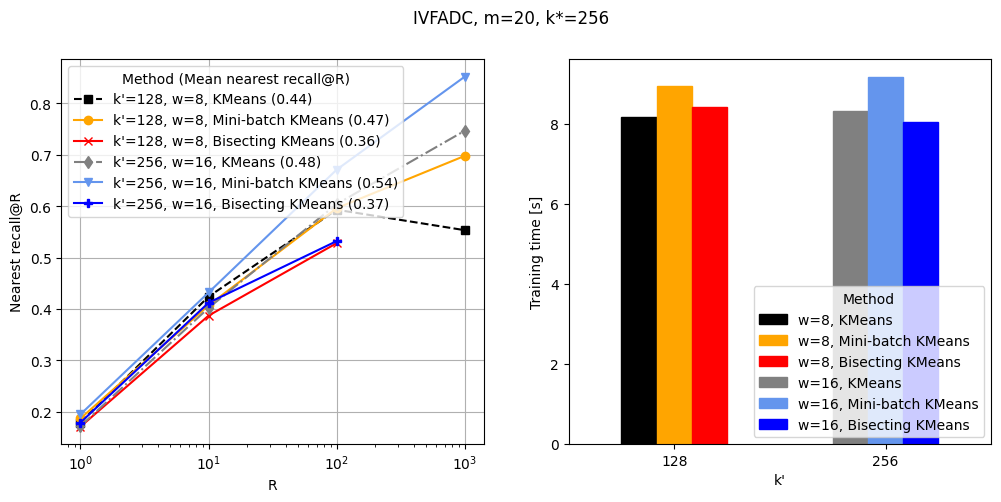

In [60]:
def compute_IVF_recall(
        M, K, KP, W, coarse_clust_alg, tr_data, search_data, queries,
        exact_ranks, seed=RANDOM_SEED):
    
    ivf = IVF(Kp=KP, M=M, K=K, seed=seed, coarse_clust_alg=coarse_clust_alg)
    start_training_ivf = time.time()
    ivf.train(tr_data, add=False)
    training_ivf = time.time() - start_training_ivf
    ivf.add(search_data, compute_distortions=False)
    results_ivf = compute_recall(ivf, R, queries, exact_ranks, w=W, correct=False, sym=False)
    return results_ivf, training_ivf

results_ivf_mini, training_ivf_mini = compute_IVF_recall(
    M, K, KP, W, "mkm", tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)
results_ivf_bis, training_ivf_bis = compute_IVF_recall(
    M, K, KP, W, "bkm", tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)
results_ivf_double, training_ivf_double = compute_IVF_recall(
    M, K, KP*2, W*2, "km", tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)
results_ivf_mini_double, training_ivf_mini_double = compute_IVF_recall(
    M, K, KP*2, W*2, "mkm", tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)
results_ivf_bis_double, training_ivf_bis_double = compute_IVF_recall(
    M, K, KP*2, W*2, "bkm", tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_ivf["nearest_asym_recall_mean"], "--s", label=f"k'={KP}, w={W}, KMeans ({np.nanmean(results_ivf['nearest_asym_recall_mean']):.2f})", color="black") 
axs[0].plot(R, results_ivf_mini["nearest_asym_recall_mean"], "-o", label=f"k'={KP}, w={W}, Mini-batch KMeans ({np.nanmean(results_ivf_mini['nearest_asym_recall_mean']):.2f})", color="orange")
axs[0].plot(R, results_ivf_bis["nearest_asym_recall_mean"], "-x", label=f"k'={KP}, w={W}, Bisecting KMeans ({np.nanmean(results_ivf_bis['nearest_asym_recall_mean']):.2f})", color="red")
axs[0].plot(R, results_ivf_double["nearest_asym_recall_mean"], "-.d", label=f"k'={KP*2}, w={W*2}, KMeans ({np.nanmean(results_ivf_double['nearest_asym_recall_mean']):.2f})", color="gray")
axs[0].plot(R, results_ivf_mini_double["nearest_asym_recall_mean"], "-v", label=f"k'={KP*2}, w={W*2}, Mini-batch KMeans ({np.nanmean(results_ivf_mini_double['nearest_asym_recall_mean']):.2f})", color="cornflowerblue")
axs[0].plot(R, results_ivf_bis_double["nearest_asym_recall_mean"], "-P", label=f"k'={KP*2}, w={W*2}, Bisecting KMeans ({np.nanmean(results_ivf_bis_double['nearest_asym_recall_mean']):.2f})", color="blue")
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title="Method (Mean nearest recall@R)")
axs[0].grid()

df = pd.DataFrame({
    "k'": [KP, KP*2],
    "Training time Bisecting KMeans": [training_ivf_bis, training_ivf_bis_double],
    "Training time KMeans": [training_ivf, training_ivf_double],
    "Training time Mini-batch KMeans": [training_ivf_mini, training_ivf_mini_double]
    })
df.set_index("k'", inplace=True)
ax = df.plot.bar(rot=0, ax=axs[1])
colors = ["black", "orange", "red", "gray", "cornflowerblue", "blue"]
for i, bar in enumerate(ax.patches):
    if i%2==0:
        bar.set_color(colors[:3][i//2])
    else:
        bar.set_color(colors[3:][i//2])
legend_patches = []
for i in range(6):
    w = W if i < 3 else W*2
    if i%3==0:
        coarse_clust_alg = "KMeans" 
    elif i%3==1:
        coarse_clust_alg = "Mini-batch KMeans"
    else:
        coarse_clust_alg = "Bisecting KMeans"
    label = f"w={w}, {coarse_clust_alg}"
    legend_patches.append(mpatches.Patch(color=colors[i], label=label))
ax.legend(handles=legend_patches, title="Method", loc="lower right")
ax.set_ylabel("Training time [s]");

fig.suptitle(f"IVFADC, m={M}, k*={K}");